In [1]:
import pandas as pd
import re
import numpy as np

# functions

In [2]:
def extract_last_bracket(string:str):
    
    """
    Extracts the content within the last set of square brackets in a given string.

    This function searches for text enclosed in square brackets ([]) within the provided string and returns the content of the last occurrence. If the string contains less than two sets of square brackets, `None` is returned. Additionally, any trailing whitespace in the extracted content is removed.

    Parameters:
    - string (str): The input string from which to extract the content within the last set of square brackets.

    Returns:
    - str or None: The content found within the last set of square brackets, stripped of trailing whitespace. Returns `None` if the string does not contain at least two sets of square brackets.

    Example:
    >>> extract_last_bracket("Example [first] text with [second] set of brackets")
    'second'
    >>> extract_last_bracket("No brackets here")
    None

    Note:
    The function assumes that the input string is well-formed and contains square brackets in pairs. It does not account for nested or malformed brackets.
    """
    
    # The string from which to extract the content
    text = string

    # Regular expression to find content within the square brackets
    matches = re.findall(r'\[(.*?)\]', text)

    # Extract the content of the second set of square brackets and remove trailing whitespace
    content = matches[1].strip() if len(matches) > 1 else None

    return content

In [3]:
def cross_analysis_one_hot(cols_first:list, cols_second:list, df):
    
    """
    Perform cross analysis between two sets of one-hot encoded columns.

    This function calculates the sum and percentage of occurrences for each combination
    of values in two lists of columns within a given DataFrame. It's particularly useful
    for analyzing the relationship between two one-hot encoded questions by generating
    a new DataFrame that summarizes these relationships.

    Parameters:
    - cols_first (list of str): Column names to be used as the index of the new DataFrame.
        These columns should be one-hot encoded and represent the first question/set of options.
    - cols_second (list of str): Column names to be used as columns of the new DataFrame.
        These columns should be one-hot encoded and represent the second question/set of options.
    - df (pd.DataFrame, optional): The DataFrame containing the columns specified in
        `cols_first` and `cols_second`. Defaults to `df_whole` if not specified.

    Returns:
    - pd.DataFrame: A DataFrame with index as `cols_first` and columns as `cols_second`,
        containing sum and percentage values for each index-column combination.
    - list: A list of the names of the percentage columns in the returned DataFrame,
        which can be used for further analysis or visualization.

    Example:
    >>> cols_first = ['Question1_OptionA', 'Question1_OptionB']
    >>> cols_second = ['Question2_OptionA', 'Question2_OptionB']
    >>> analysis_df, percentage_cols = cross_analysis_one_hot(cols_first, cols_second, df=my_dataframe)
    This will return a DataFrame with the cross analysis of specified options and
    a list of column names representing the percentage values.
    """
    
    # initialize empty DataFrame
    aggregated_df = pd.DataFrame(index=cols_first, columns=cols_second).fillna(0)

    for level_index in cols_first:
        for level_cols in cols_second:
            # Sum the age counts for the current career path
            aggregated_df.loc[level_index, level_cols] = df[df[level_index] == True][level_cols].sum()
        
    # rename indices and column names
    aggregated_df.columns = cols_second

    #aggregated_df.index = career
    aggregated_df['totals'] = aggregated_df.sum(axis=1)
    
    ls_perc_columns = []
    for col in aggregated_df.loc[:, aggregated_df.columns != 'totals'].columns:
        percentage_column_name = f'{col}Percentage'
        ls_perc_columns.append(percentage_column_name)
        aggregated_df[percentage_column_name] = np.divide(aggregated_df[col], aggregated_df['totals'].replace(0, np.nan)) * 100
        
    
    
    return aggregated_df, ls_perc_columns

In [4]:
def cross_analysis_non_one_hot(col_name:str, oh_cols:list, df, transpose=False):
    
    """
    Performs aggregation and analysis on a dataset based on a specified non-one-hot-encoded column 
    against multiple one-hot-encoded columns. It calculates the sum and percentage of True values 
    for each one-hot-encoded column grouped by the unique values in the non-one-hot-encoded column.

    Parameters:
    - col_name (str): The name of the non-one-hot-encoded column to group the data by.
    - oh_cols (list of str): A list containing the names of the one-hot-encoded columns to be analyzed.
    - df (pd.DataFrame, optional): The DataFrame to perform the analysis on. Defaults to `df_whole`.
    - transpose (bool, optional): If set to True, the resulting DataFrame is transposed, 
      making the aggregated categories the columns instead of the rows. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame with aggregated sum and percentage values for each category 
      in the non-one-hot-encoded column. If `transpose` is True, the DataFrame is transposed.
    - list: A list of the names of the percentage columns in the returned DataFrame, 
      which can be used for further analysis or visualization.

    The resulting DataFrame includes a 'totals' column that sums the occurrences for all 
    one-hot-encoded columns, and additional columns representing the percentage of each 
    one-hot-encoded column's True values relative to the 'totals'.

    Example:
    >>> col_name = 'Department'
    >>> oh_cols = ['ProjectCompleted', 'ProjectInProgress']
    >>> aggregated_df, percentage_cols = cross_analysis_non_one_hot(col_name, oh_cols, df=my_dataframe)
    >>> print(aggregated_df)
    
    This example would group `my_dataframe` by 'Department', aggregating data for 'ProjectCompleted' 
    and 'ProjectInProgress', and calculating the percentage of each within departments.
    """
    
    
    # Initialize aggregation dictionary
    agg_dict = {col: pd.NamedAgg(column=col, aggfunc='sum') for col in oh_cols}
    
    # Aggregate the data
    df_aggregated = df.groupby(col_name).agg(**agg_dict).reset_index()
    
    if not transpose:
        # Calculate totals
        df_aggregated['totals'] = df_aggregated[oh_cols].sum(axis=1)

        # Calculate percentages for each one-hot-encoded column
        ls_perc_columns = []
        for col in oh_cols:
            percentage_col = f'{col}Perc'
            ls_perc_columns.append(percentage_col)
            # Use numpy to handle division by zero
            df_aggregated[percentage_col] = np.divide(df_aggregated[col], df_aggregated['totals'].replace(0, np.nan)) * 100
            df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle NaNs from division by zero
    else: 
        df_aggregated = df_aggregated.T
        df_aggregated.columns = [f"{df_aggregated.index[0]}_{df_aggregated.iloc[0, i]}_sum" for i in range(len(df_aggregated.columns))]
        df_aggregated.drop(index=df_aggregated.index[0], inplace=True)
        df_aggregated['totals'] = df_aggregated.sum(axis=1)
        
        ls_perc_columns = []
        for col in df_aggregated.columns[:-1]:  # Exclude 'totals' from the percentage calculation
            percentage_col = f'{col}Perc'
            ls_perc_columns.append(percentage_col)
            # Use numpy to handle division by zero
            df_aggregated[percentage_col] = np.divide(df_aggregated[col], df_aggregated['totals'].replace(0, np.nan)) * 100
            df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle NaNs from division by zero

    return df_aggregated, ls_perc_columns

In [5]:
def inversed_legend(ax, ls_categories_legend):
    
    """
    Updates the plot's legend to reflect the inverse order of categories, aligning the legend order with the visual stacking order in a bar plot.

    This function is designed to work with matplotlib plots where the visual stacking order of elements is opposite to the desired legend order. It reverses the legend's label and handle order to match the plot's visual representation, ensuring that the legend accurately reflects the stacking order.

    Parameters:
    - ls_categories_legend (list of str): A list containing the labels for the legend in the desired order. This list will be reversed internally to match the visual stacking order in the plot.

    Notes:
    - The function assumes that the matplotlib Axes object `ax` is defined in the global scope or accessible in the calling context.
    - The legend's location is set to 'center left' with a bbox_to_anchor at (1, 0.75), which places the legend outside the plot area. Adjust these parameters as necessary to fit the plot layout.

    Example usage:
    ```python
    # Assuming a matplotlib plot has been created and `ax` is the current Axes object
    ls_categories_legend = ['Category 1', 'Category 2', 'Category 3']
    inversed_legend(ls_categories_legend)
    ```

    This function will reverse both the handles and labels of the legend to match the plot's visual stacking order, starting with 'Category 3' at the top and ending with 'Category 1' at the bottom.
    """

    # Reverse the order of labels to match the visual stacking order in the plot
    reversed_labels = ls_categories_legend[::-1]

    # Get the current handles from the plot
    handles, _ = ax.get_legend_handles_labels()

    # Reverse the order of handles to match the reversed order of labels
    reversed_handles = handles[::-1]

    # Set the new legend with reversed handles and labels
    ax.legend(reversed_handles, reversed_labels, loc='center left', bbox_to_anchor=(1, 0.75))

In [6]:
def title_legend_extract(dict_prefix_columns:dict, key:str):
    # Lists to store the extracted substrings
    substring2_list = []
    substring3_list = []

    # Regular expression pattern to match the strings and capture substring2 and substring3
    pattern = re.compile(r"\.([^\._\[]+)[_\[]([^\]]*)")

    for s in dict_prefix_columns[key]:
        match = pattern.search(s)
        if match:
            # Extract and store substring2 and substring3
            substring2_list.append(match.group(1))
            substring3_list.append(match.group(2))
        
    return substring2_list[0], substring3_list

In [7]:
def title_extract(dict_prefix_columns:dict, key:str):
    # Pattern to capture the question part of the string
    pattern = re.compile(r"\. ([^?]+)\?")
    
    match = pattern.search(str(dict_prefix_columns[key]))
    if match:
        substring2 = match.group(1)
        # Assuming \xa0 or similar trailing characters are not needed
        return substring2
    else:
        return None

In [8]:
def stacked_bar_graph(df, cols_perc, title_name, ls_x_ticks:list, str_x_label:str, ls_legend_levels, dir_to_save, data_name):
    ax = df[cols_perc].plot(kind='bar', 
                            stacked=True, 
                            figsize=(8, 6),                                                                                        
                            xlabel=str_x_label,
                            width=0.9,
                            title=title_name
                                    )
    
    ax.set_ylabel('Prozent')

    # add percentage labels into the bars
    for c in ax.containers:
        # Optional: if the segment is small or 0, customize the labels
        labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
        # remove the labels parameter if it's not needed for customized labels
        ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
        
    ax.set_xticklabels(ls_x_ticks, rotation=45, ha='right', rotation_mode='anchor')

    inversed_legend(ax, ls_legend_levels)
        
    #add total values of entries above bar
    y_offset = 4
    for i, total in enumerate(df['totals']):
        ax.text(df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
        weight='bold')

    ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
    
    fig = ax.get_figure()
    fig.savefig(f'{dir_to_save}{data_name}', bbox_inches='tight', dpi=300)

# import and define column variables

In [9]:
df_freelancer = pd.read_csv('../data/processed/02_cleaned_data_F.csv')
df_freelancer.shape

(115, 266)

convert numeric columns that are actually boolean columns to boolean columns

In [10]:
# Step 1: Identify numeric columns
numeric_cols = df_freelancer.select_dtypes(include=['number']).columns

# Step 2: Find numeric columns with only 0s, 1s, and potentially NAs
cols_to_convert = []
for col in numeric_cols:
    # Drop NA values for the unique check
    unique_vals = df_freelancer[col].dropna().unique()
    if set(unique_vals).issubset({0, 1}):
        cols_to_convert.append(col)

# Step 3: Convert those columns to boolean, preserving NA values
for col in cols_to_convert:
    # Use to_numeric with errors='coerce' to ensure NAs are preserved
    df_freelancer[col] = pd.to_numeric(df_freelancer[col], errors='coerce').astype('boolean')

# df now has those columns converted to boolean, with NA values preserved

In [11]:
ls_cols_age_level = [col for col in df_freelancer.columns if col.endswith('.0')]
order = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 2]
ls_cols_age_level = [ls_cols_age_level[i] for i in order]
ls_decoded_age_level = ['Unter 25',
                     '25-29',
                     '30-34',
                     '35-39',
                     '40-44',
                     '45-49',
                     '50-54',
                     '55-59',
                     '60-64',
                     '65-69',
                     'Über 70']
ls_cols_age_level

['AP1. Wie alt sind Sie?_0.0',
 'AP1. Wie alt sind Sie?_1.0',
 'AP1. Wie alt sind Sie?_2.0',
 'AP1. Wie alt sind Sie?_3.0',
 'AP1. Wie alt sind Sie?_4.0',
 'AP1. Wie alt sind Sie?_5.0',
 'AP1. Wie alt sind Sie?_6.0',
 'AP1. Wie alt sind Sie?_7.0',
 'AP1. Wie alt sind Sie?_8.0',
 'AP1. Wie alt sind Sie?_9.0',
 'AP1. Wie alt sind Sie?_10.0']

In [12]:
ls_cols_career_level = [col for col in df_freelancer.columns if col.startswith('AP2[')]
print(ls_cols_career_level)
ls_career_level = [extract_last_bracket(item) for item in ls_cols_career_level]
print(ls_career_level)

['AP2[SQ001]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Bachelor of Arts: ]', 'AP2[SQ002]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Master of Arts:]', 'AP2[SQ003]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Magister Artium:]', 'AP2[SQ004]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [I. Staatsexamen:]', 'AP2[SQ005]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [II. Staatsexamen:]', 'AP2[SQ006]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Diplom:]', 'AP2[SQ007]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Dr. phil.:]', 'AP2[SQ008]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben?\xa0\xa0\xa0 [Dr. phil. habil. bzw. PD:]', 'AP2[SQ009]. Welchen akademischen Grad habe

In [13]:
ls_cols_gender = [col for col in df_freelancer.columns if col.startswith('CO6')]
print(ls_cols_gender)
ls_gender_level = [item.split(sep='_')[-1] for item in ls_cols_gender]
print(ls_gender_level)

['CO6. Welchem Geschlecht ordnen Sie sich zu?_Divers', 'CO6. Welchem Geschlecht ordnen Sie sich zu?_Männlich', 'CO6. Welchem Geschlecht ordnen Sie sich zu?_Weiblich']
['Divers', 'Männlich', 'Weiblich']


In [14]:
ls_cols_care = [col for col in df_freelancer.columns if col.startswith('CO2')]
print(ls_cols_care)
ls_care_level = [extract_last_bracket(item) for item in ls_cols_care]
print(ls_care_level)

['CO2[SQ001]. Übernehmen Sie Betreuungsverantwortung? [Keine ]', 'CO2[SQ002]. Übernehmen Sie Betreuungsverantwortung? [Kind bzw. Kinder]', 'CO2[SQ003]. Übernehmen Sie Betreuungsverantwortung? [Pflegebedürftige Angehörige]']
['Keine', 'Kind bzw. Kinder', 'Pflegebedürftige Angehörige']


In [15]:
ls_col_care = [col for col in df_freelancer.columns if col.startswith('CO1.')]
print(ls_col_care)
df_freelancer[ls_col_care].value_counts()

['CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?']


CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?
False                                                             60
True                                                              51
Name: count, dtype: int64

In [16]:
ls_cols_volunteering = [col for col in df_freelancer.columns if col.startswith('AP12.')]
print(ls_cols_volunteering)
ls_volunteering_level = [item.split(sep='_')[-1] for item in ls_cols_volunteering]
print(ls_volunteering_level)

['AP12. Engagieren Sie sich ehrenamtlich im kunstwissenschaftlichen Bereich?\xa0_0', 'AP12. Engagieren Sie sich ehrenamtlich im kunstwissenschaftlichen Bereich?\xa0_1', 'AP12. Engagieren Sie sich ehrenamtlich im kunstwissenschaftlichen Bereich?\xa0_Ja, in der Vergangenheit']
['0', '1', 'Ja, in der Vergangenheit']


In [17]:
ls_col_working_hours = [col for col in df_freelancer.columns if col.startswith('AP11[')]
df_freelancer[ls_col_working_hours].value_counts()

AP11[SQ001]. Wie viele Stunden arbeiten Sie aktuell im Durchschnitt pro Woche?  [In Ziffern:]
40.0                                                                                             24
30.0                                                                                             19
50.0                                                                                             10
35.0                                                                                              9
20.0                                                                                              8
25.0                                                                                              6
45.0                                                                                              6
60.0                                                                                              5
2.0                                                                                               2
24.0  

In [18]:
ls_cols_workplace = [col for col in df_freelancer.columns if col.startswith('CO8')]
print(ls_cols_workplace)
ls_workplace_levels = [extract_last_bracket(item) for item in ls_cols_workplace]
ls_workplace_levels

['CO8[SQ001]. Welche Orte nutzen Sie als Arbeitsplatz? [Institutionell finanziertes Büro]', 'CO8[SQ002]. Welche Orte nutzen Sie als Arbeitsplatz? [Selbstfinanziertes Büro bzw. Co-Working-Space]', 'CO8[SQ003]. Welche Orte nutzen Sie als Arbeitsplatz? [Steuerlich absetzbares Arbeitszimmer im Haushalt]', 'CO8[SQ004]. Welche Orte nutzen Sie als Arbeitsplatz? [Schreibtisch im Haushalt]', 'CO8[SQ005]. Welche Orte nutzen Sie als Arbeitsplatz? [Multifunktional genutzter Platz im Haushalt]', 'CO8[SQ006]. Welche Orte nutzen Sie als Arbeitsplatz? [Bibliothek]']


['Institutionell finanziertes Büro',
 'Selbstfinanziertes Büro bzw. Co-Working-Space',
 'Steuerlich absetzbares Arbeitszimmer im Haushalt',
 'Schreibtisch im Haushalt',
 'Multifunktional genutzter Platz im Haushalt',
 'Bibliothek']

In [19]:
ls_cols_F = [col for col in df_freelancer.columns if col.startswith('F')]
ls_cols_F

['F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_0',
 'F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_1',
 'F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_Sonstiges',
 'F10r[SQ001]. Ihre letzten Honorare (brutto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Höchstes (in Euro pro Stunde):]',
 'F10r[SQ002]. Ihre letzten Honorare (brutto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Niedrigstes (in Euro pro Stunde):]',
 'F10s[SQ001]. Ihre letzten Honorare (brutto für netto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Höchstes (in Euro pro Stunde): ]',
 'F10s[SQ002]. Ihre letzten Honorare (brutto für netto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Niedrigstes (in Euro pro Stunde):]',
 'F11. Wie hat sich Ihr Honorar in den letzten Jahren entwickelt?_Abgesenkt',
 'F11. Wie hat sich Ihr Honorar in den letzten Jahren entwickelt?_Erhöht und nicht

In [20]:
# write column names to txt
name = df_freelancer[ls_cols_F].columns.to_list()
with open(r'../data/interim/col_names_df_freelancer.txt', 'w') as fp:
    for item in name:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


create a dictionary with grouped column names that are needed to create graphs automatically

In [21]:
# The complete list of column names from the file content
column_names = ls_cols_F

# Process to group column names based on the prefix and special characters
from collections import defaultdict

#Adjusting the regular expression to account for prefixes that can end with '.', 'r', 's', 't', or '['
def extract_prefix_group(column_name):

    # Adjusted regular expression to capture the specified conditions

    match = re.match(r'([A-Za-z]+\d+[.|rst]?)(\[)?.*', column_name)
    if match:
        prefix = match.group(1)
        suffix = match.group(2) if match.group(2) else ''
        # Include 'r', 's', 't', or '[' in the prefix group if present
        return f"{prefix}{suffix}"
    return None



# group column names with prefixes
adjusted_groups = defaultdict(list)
for name in column_names:
    prefix_group = extract_prefix_group(name)
    if prefix_group:
        adjusted_groups[prefix_group].append(name)

# Displaying the adjusted groups
for group, names in adjusted_groups.items():
    print(f"Group: {group}, Entries: {len(names)}")

adjusted_groups

Group: F10., Entries: 3
Group: F10r[, Entries: 2
Group: F10s[, Entries: 2
Group: F11., Entries: 4
Group: F11r[, Entries: 1
Group: F11s[, Entries: 1
Group: F12., Entries: 3
Group: F13[, Entries: 3
Group: F13r[, Entries: 3
Group: F13s[, Entries: 2
Group: F14[, Entries: 3
Group: F15[, Entries: 2
Group: F16., Entries: 3
Group: F16r[, Entries: 1
Group: F16s, Entries: 1
Group: F17., Entries: 3
Group: F18., Entries: 1
Group: F18r[, Entries: 6
Group: F19[, Entries: 3
Group: F1[, Entries: 4
Group: F2., Entries: 2
Group: F20[, Entries: 10
Group: F21., Entries: 1
Group: F21r, Entries: 3
Group: F21s, Entries: 2
Group: F22., Entries: 1
Group: F22r[, Entries: 3
Group: F23., Entries: 3
Group: F24., Entries: 3
Group: F3[, Entries: 3
Group: F3r, Entries: 2
Group: F3s[, Entries: 4
Group: F4[, Entries: 11
Group: F5[, Entries: 4
Group: F6., Entries: 2
Group: F7[, Entries: 12
Group: F8[, Entries: 1
Group: F9[, Entries: 3
Group: F9r[, Entries: 3
Group: F9s[, Entries: 8
Group: F9t[, Entries: 2


defaultdict(list,
            {'F10.': ['F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_0',
              'F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_1',
              'F10. Nehmen Sie aktuell die Kleinunternehmerregelung nach § 19 UStG in Anspruch?_Sonstiges'],
             'F10r[': ['F10r[SQ001]. Ihre letzten Honorare (brutto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Höchstes (in Euro pro Stunde):]',
              'F10r[SQ002]. Ihre letzten Honorare (brutto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Niedrigstes (in Euro pro Stunde):]'],
             'F10s[': ['F10s[SQ001]. Ihre letzten Honorare (brutto für netto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Höchstes (in Euro pro Stunde): ]',
              'F10s[SQ002]. Ihre letzten Honorare (brutto für netto) unter Einrechnung des kompletten Arbeitsaufwandes:\xa0 [Niedrigstes (in Euro pro Stunde):]'],
             'F11.': [

In [22]:
ls_prefix = list(adjusted_groups.keys())

In [23]:
ls_col_var_names = [f"ls_{prefix}" for prefix in adjusted_groups.keys()]

NEEDED for automated graphs:
* dataframe with aggregated values
* list of percentage columns
* all columns of a group
* For title: Prefix_everything after '.' until either ':' or '_'
* For legend: everything after '_' or inside last square brackets

In [24]:
# all columns of a group
adjusted_groups['F13[']

['F13[SQ001]. Bekommen Sie Ausfallhonorare? [Ausnahmsweise]',
 'F13[SQ002]. Bekommen Sie Ausfallhonorare? [Ja, regulär]',
 'F13[SQ003]. Bekommen Sie Ausfallhonorare? [Nein]']

In [25]:
def title_legend_extract(dict_prefix_columns:dict, key:str):
    # Lists to store the extracted substrings
    substring2_list = []
    substring3_list = []

    # Regular expression pattern to match the strings and capture substring2 and substring3
    pattern = re.compile(r"\.([^\._\[]+)[_\[]([^\]]*)")

    for s in dict_prefix_columns[key]:
        match = pattern.search(s)
        if match:
            # Extract and store substring2 and substring3
            substring2_list.append(match.group(1))
            substring3_list.append(match.group(2))
        
    return substring2_list[0], substring3_list
    

In [26]:
adjusted_groups.keys()

dict_keys(['F10.', 'F10r[', 'F10s[', 'F11.', 'F11r[', 'F11s[', 'F12.', 'F13[', 'F13r[', 'F13s[', 'F14[', 'F15[', 'F16.', 'F16r[', 'F16s', 'F17.', 'F18.', 'F18r[', 'F19[', 'F1[', 'F2.', 'F20[', 'F21.', 'F21r', 'F21s', 'F22.', 'F22r[', 'F23.', 'F24.', 'F3[', 'F3r', 'F3s[', 'F4[', 'F5[', 'F6.', 'F7[', 'F8[', 'F9[', 'F9r[', 'F9s[', 'F9t['])

In [27]:
title, legend = title_legend_extract(adjusted_groups, 'F11.')
print(title)
print(legend)

 Wie hat sich Ihr Honorar in den letzten Jahren entwickelt?
['Abgesenkt', 'Erhöht und nicht durch Preisentwicklung getilgt', 'Real gesunken: Preisentwicklung übersteigt Honorarerhöhungen (vergleichbar mit Reallohnverlust bei Angestellten)', 'Stagniert real: Honorare bzw. Honorarerhöhungen werden von Preisentwicklung getilgt']


Pseudofunction:
* take following arguments: list of columns for x axis, dictionary of prefixes and columns to cross analyse with, dataframe
* for every key in dictionary: check if columns are boolean or numbers
    * if columns are boolean: check if there are more than one columns in the list
        * if yes: cross_analysis_one_hot
        * else: cross_analysis_non_onehot with transpose = True
            * stacked bar plot
    * if columns are numeric: scatter plot


In [28]:
def automated_graphs(ls_cols_x_axis:list, dict_prefix_columns:dict, name_prefix_x_axis:str, ls_x_ticks, str_x_label, df=df_freelancer, dir_to_save='../reports/figures/freelancer/'):
    i = 0
    #ls_temp_0 = []
    #ls_temp_1 = []
    for key in dict_prefix_columns.keys():
        i = i+1
        numeric_object = f"{i:03}"
        if (all(df[dict_prefix_columns[key]].dtypes == bool)) | (all(df[dict_prefix_columns[key]].dtypes == 'boolean')):
            #ls_temp_0.append(key)
            if df[dict_prefix_columns[key]].shape[1] > 1:
                #ls_temp_1.append(key)
                temp_df, temp_perc = cross_analysis_one_hot(ls_cols_x_axis, dict_prefix_columns[key], df)
                title, legend_levels = title_legend_extract(dict_prefix_columns, key)
                title = f'{key}_{title}'
                data_name = f'F_{numeric_object}_{name_prefix_x_axis}_{title}.png'
                stacked_bar_graph(temp_df, temp_perc, title, ls_x_ticks, str_x_label, legend_levels, dir_to_save, data_name)
            elif df[dict_prefix_columns[key]].shape[1] == 1:
                temp_df, temp_perc = cross_analysis_non_one_hot(dict_prefix_columns[key], ls_cols_x_axis, df, transpose=True)
                title = title_extract(dict_prefix_columns, key)
                title = f'{key}_{title}'
                legend_levels = ['Nein', 'Ja']
                data_name = f'F_{numeric_object}_{name_prefix_x_axis}_{title}.png'
                stacked_bar_graph(temp_df, temp_perc, title, ls_x_ticks, str_x_label, legend_levels, dir_to_save, data_name)
        else:
            if all(df[adjusted_groups[key]].dtypes.apply(lambda x: np.issubdtype(x, np.number))):
                temp_df = df.copy(deep=True)
                temp_df['Group'] = df[ls_cols_x_axis].idxmax(axis=1)
                temp_df['Group'].apply(lambda x: x.split(sep='_')[1])
                for col in df[adjusted_groups[key]]:
                    title = col
                    data_name = f'F_{numeric_object}_{name_prefix_x_axis}_{title}.png'
                    ax = temp_df.boxplot(by='Group', column=col, grid=False)
                    ax.set_xlabel(str_x_label)
                    ax.set_xticklabels(ls_x_ticks, rotation=45)
                    ax.set_ylabel(title)
                    ax.set_title(title)
                    ax.figure.suptitle('')  # Remove the automatic 'Boxplot grouped Group' title
                    fig = ax.get_figure()
                    fig.savefig(f'{dir_to_save}{data_name}', bbox_inches='tight', dpi=300)


/home/micha/anaconda3/envs/Ulmer_Verein/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


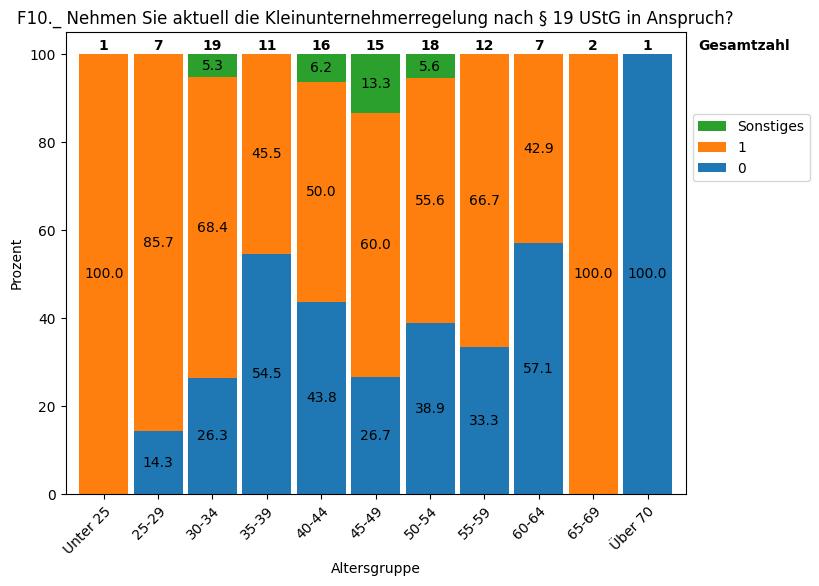

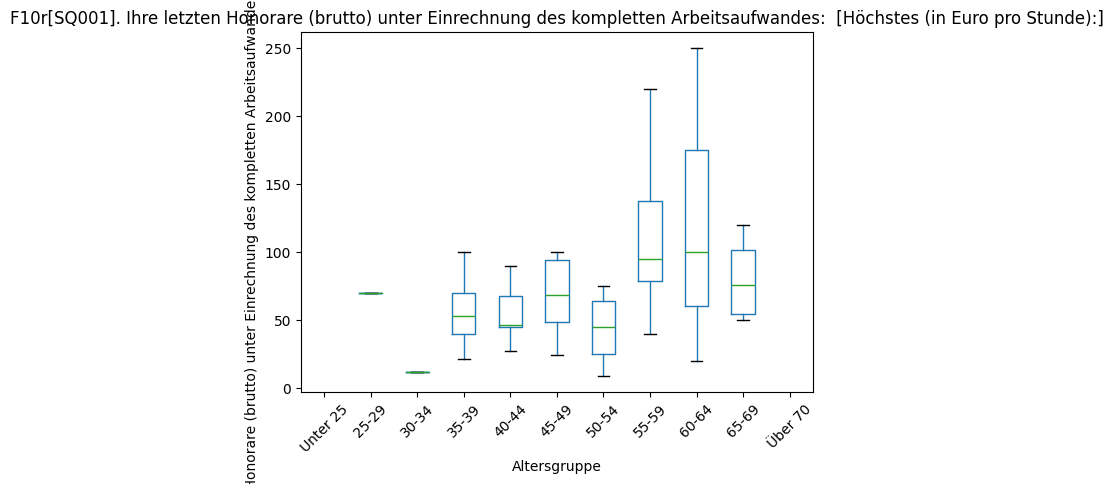

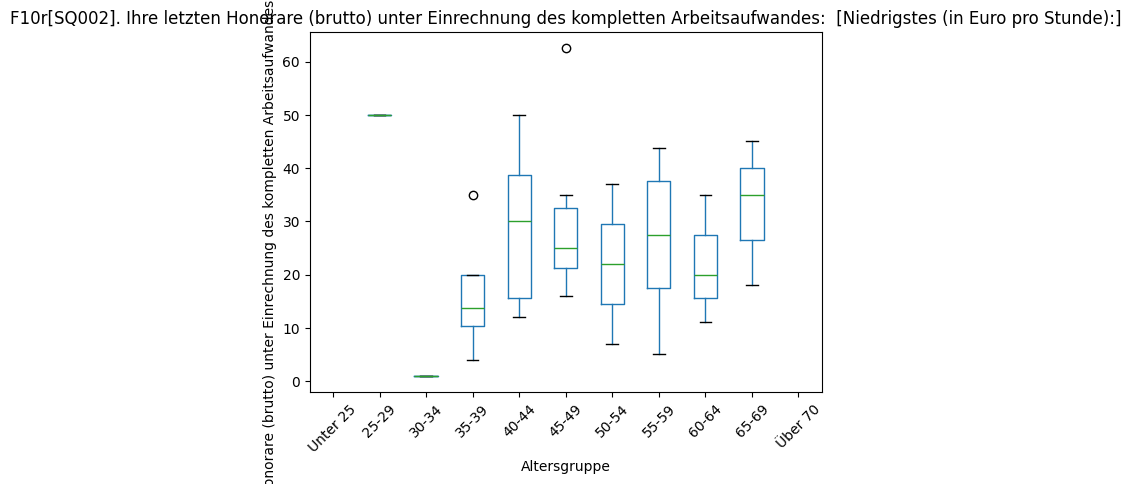

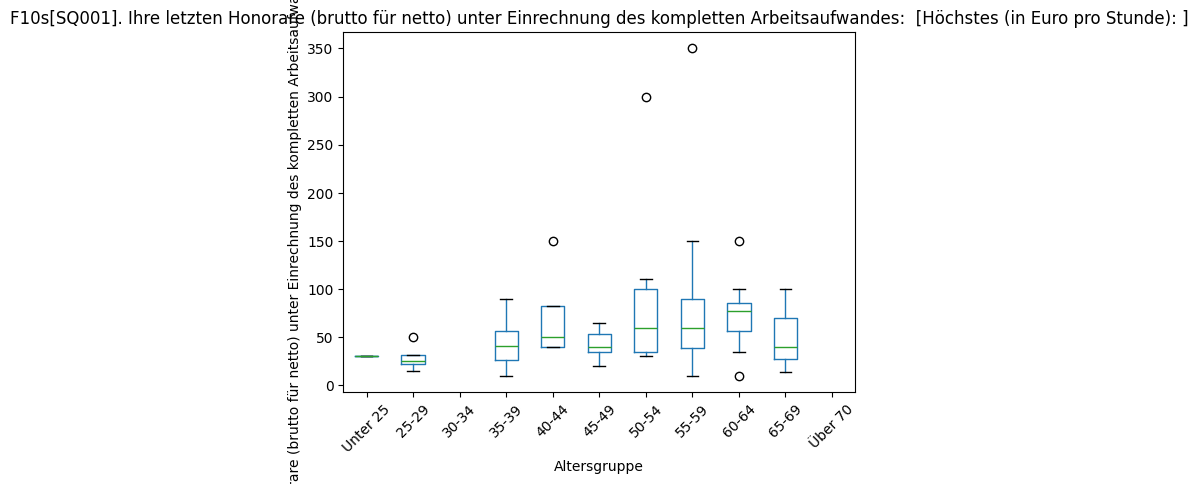

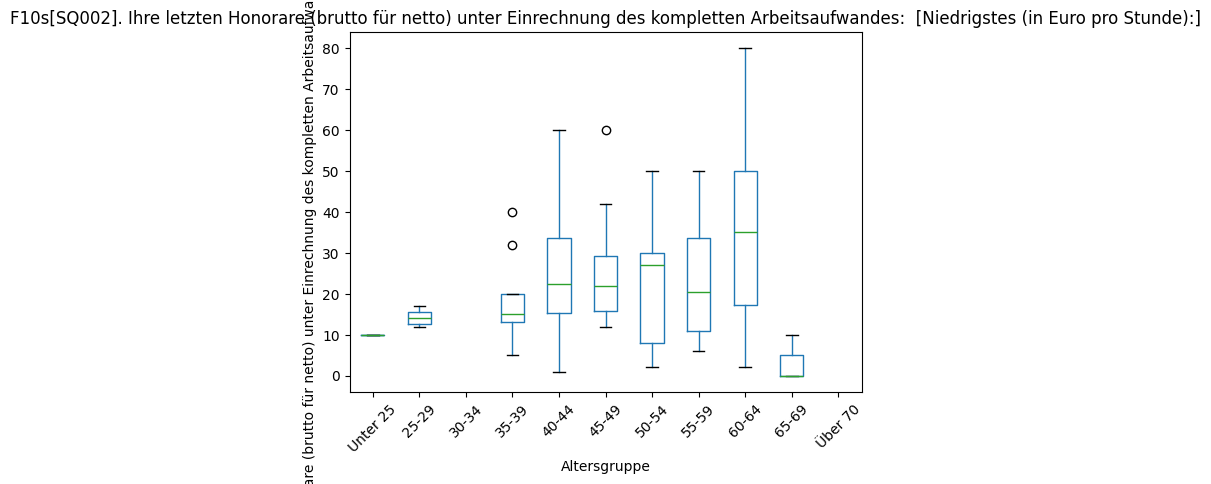

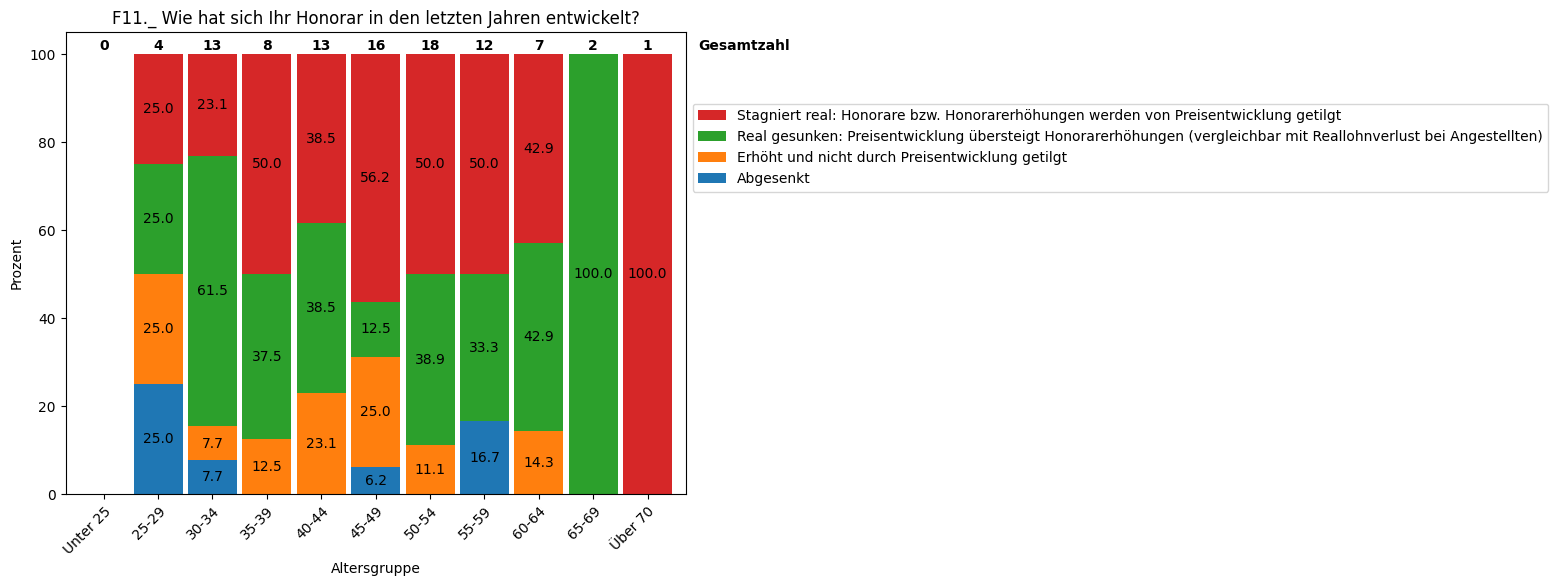

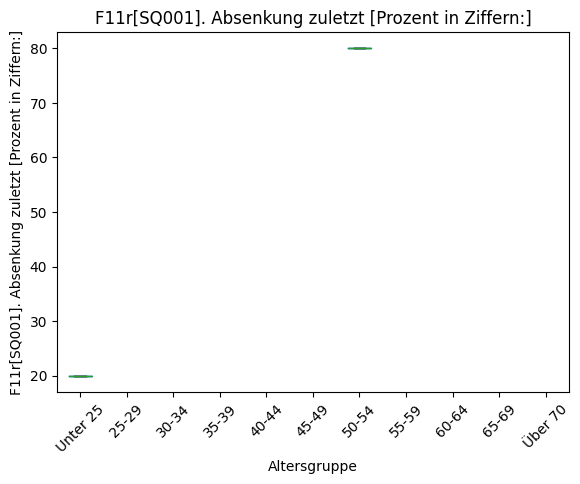

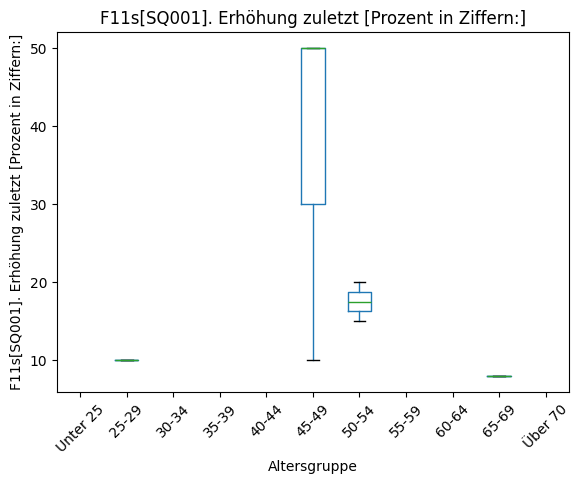

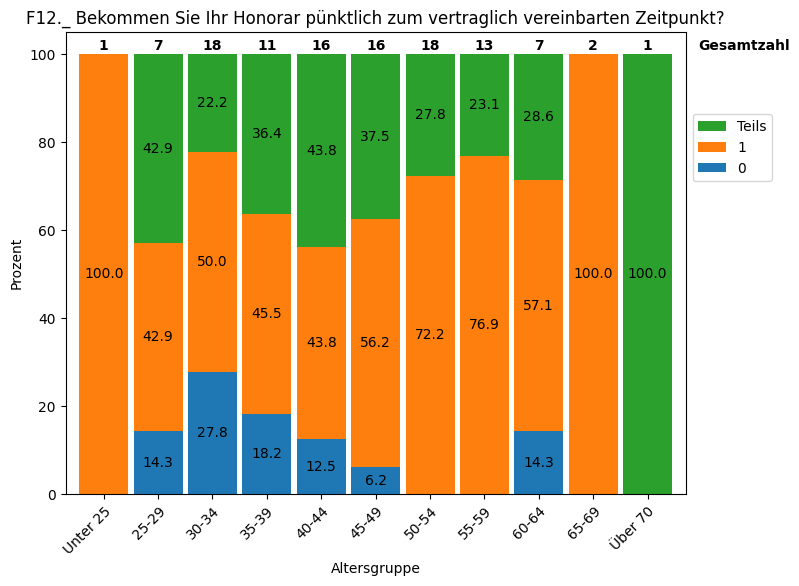

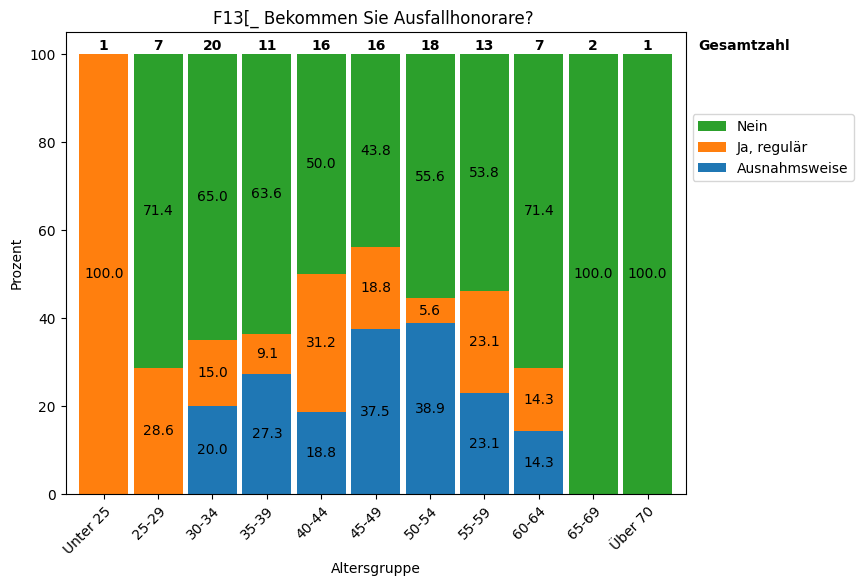

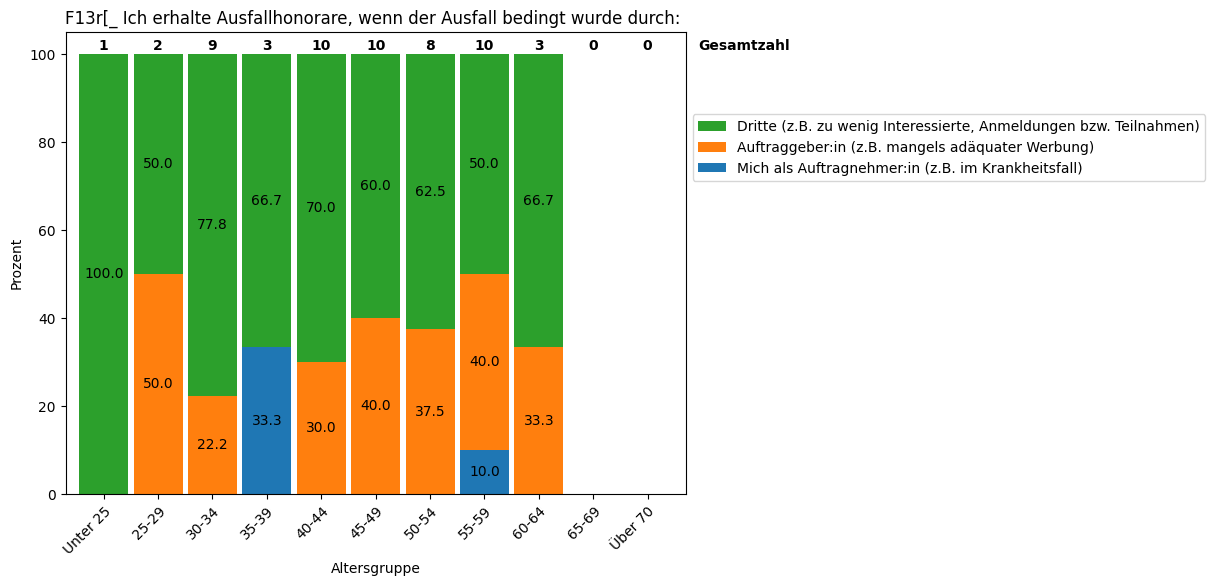

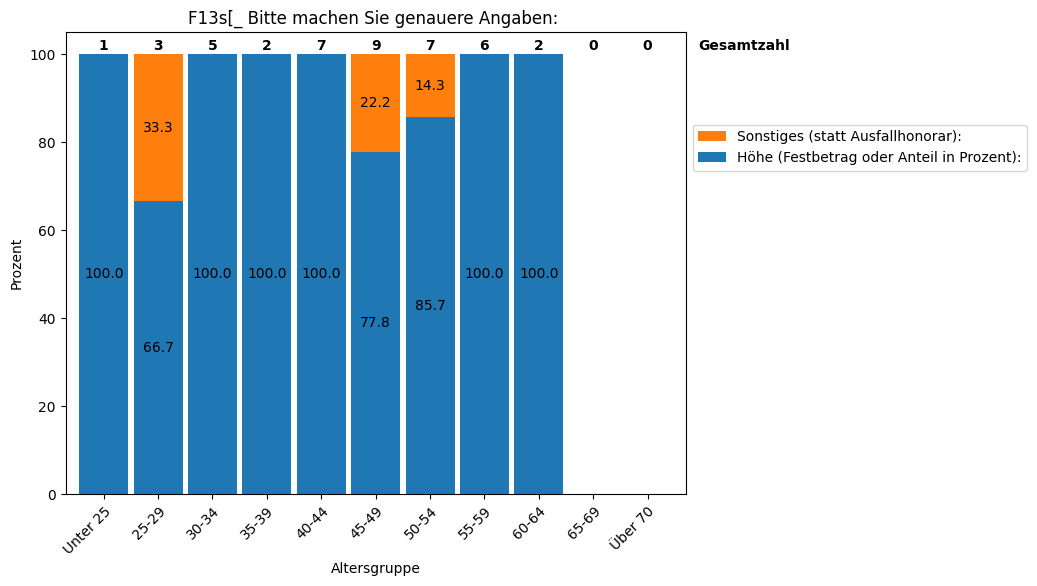

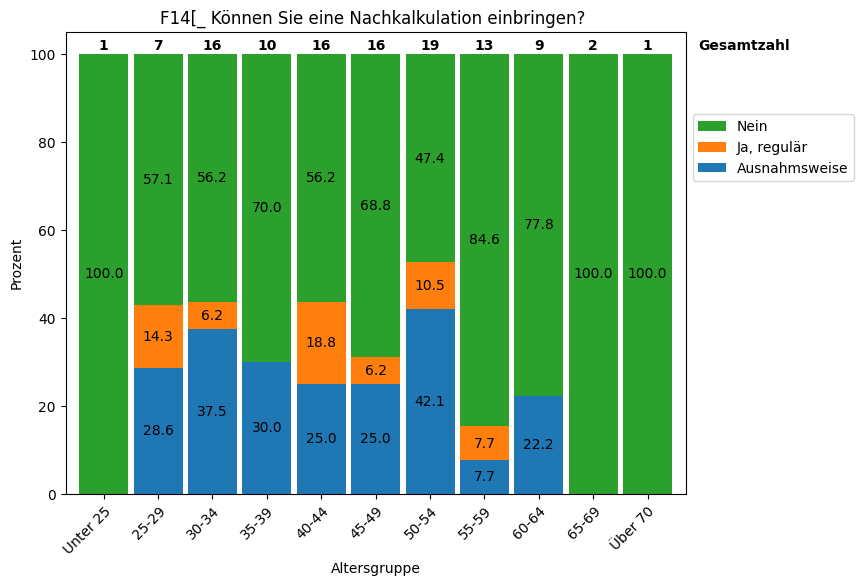

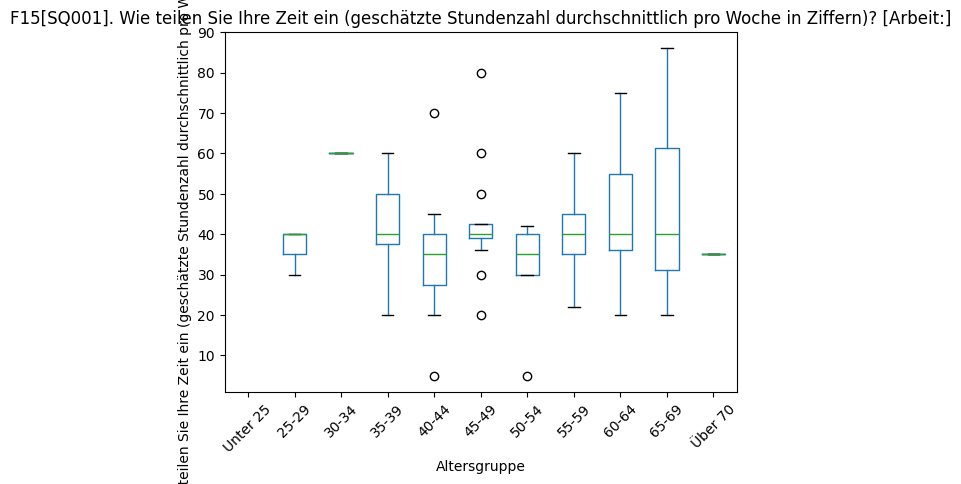

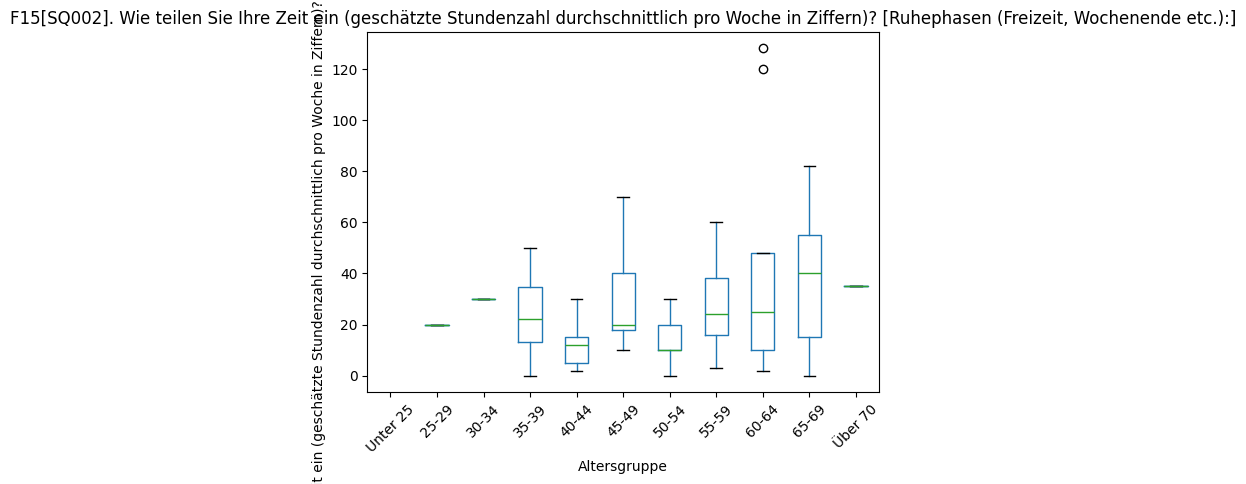

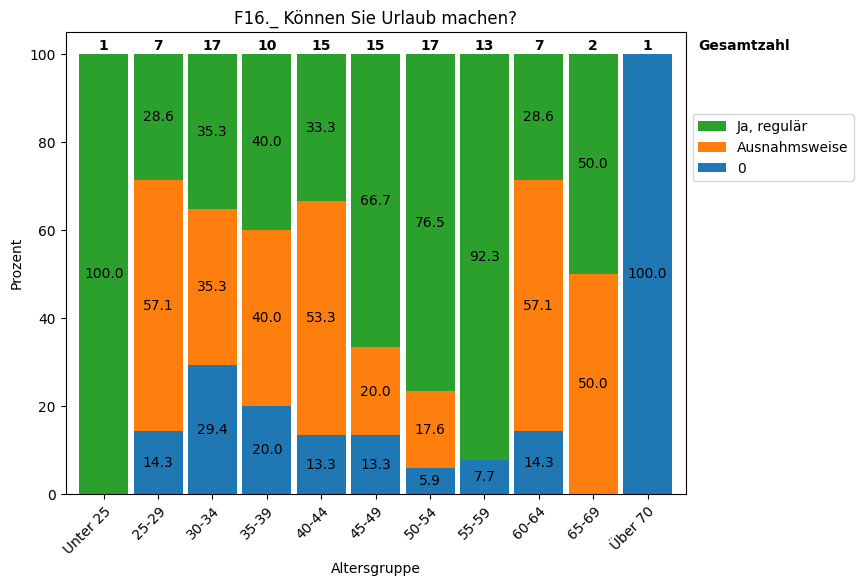

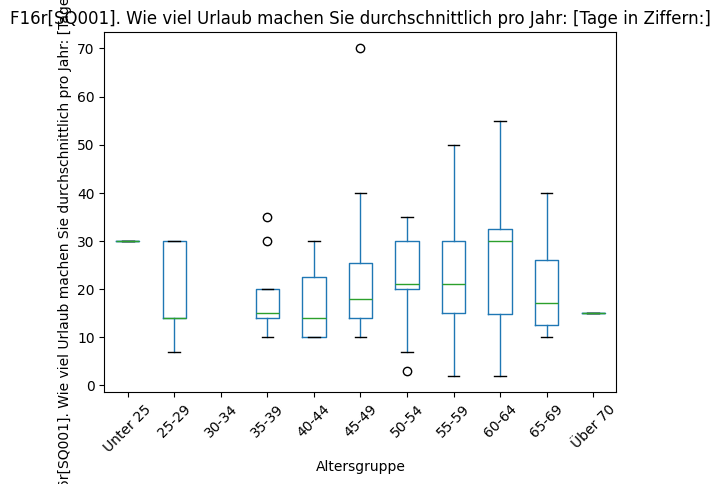

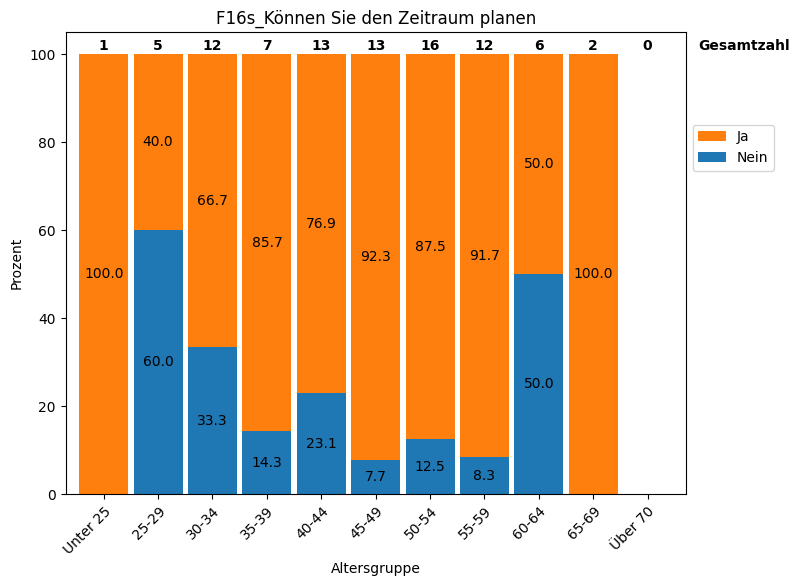

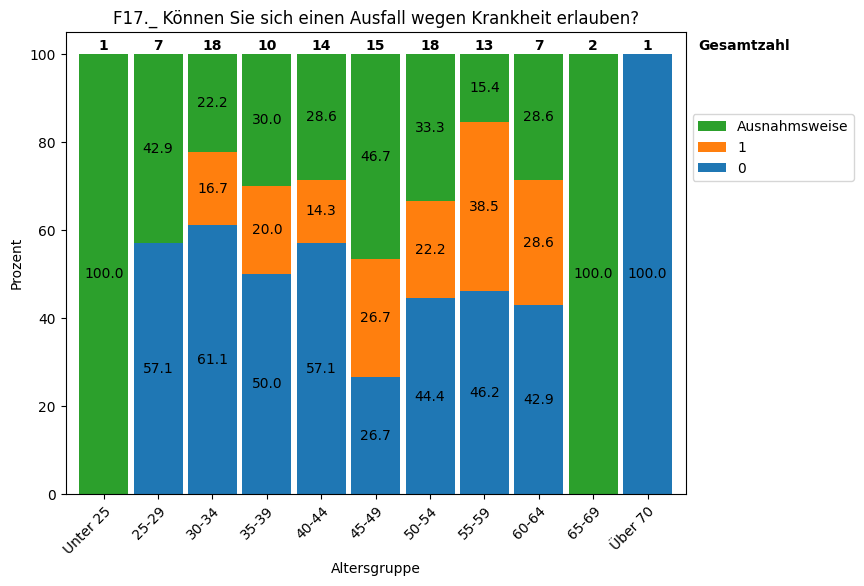

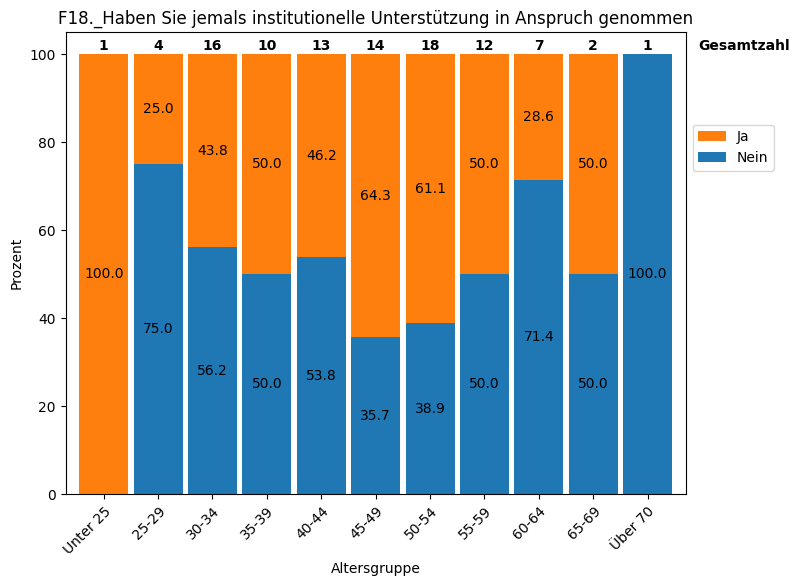

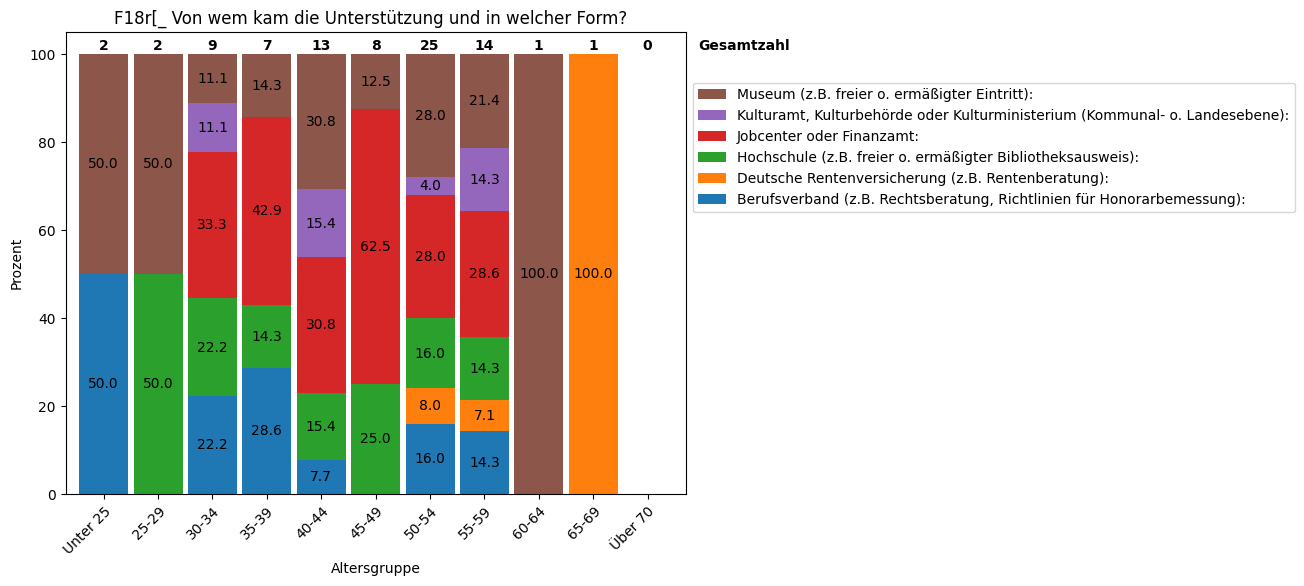

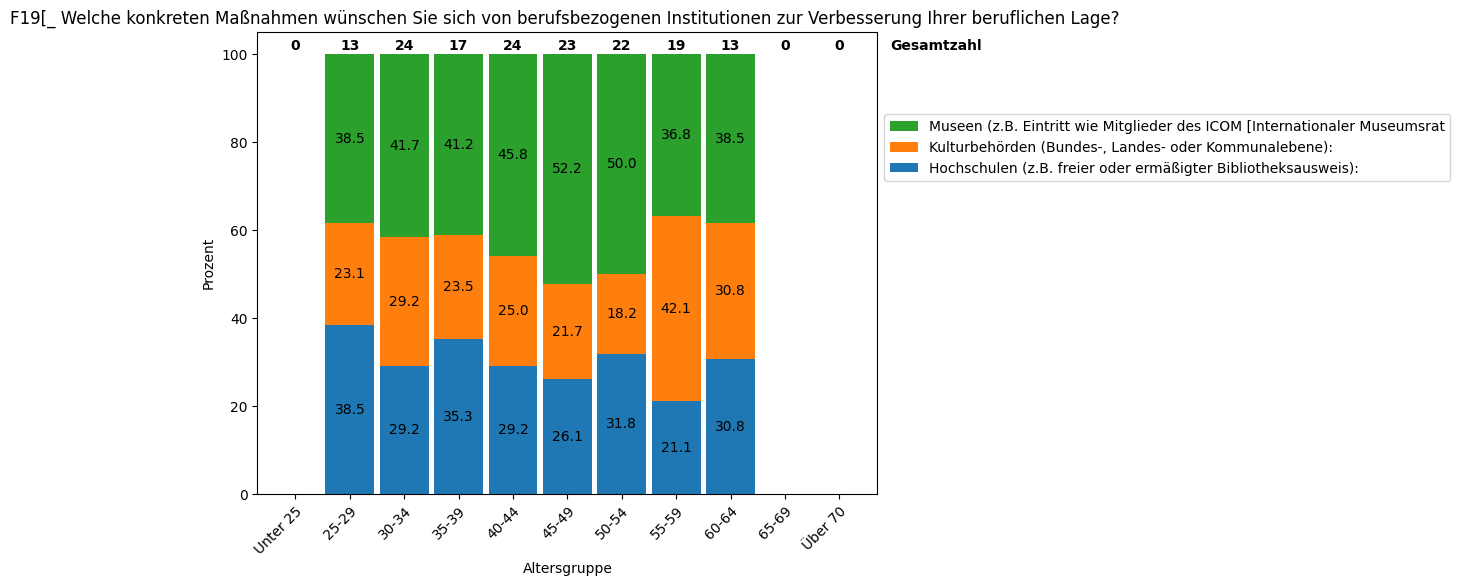

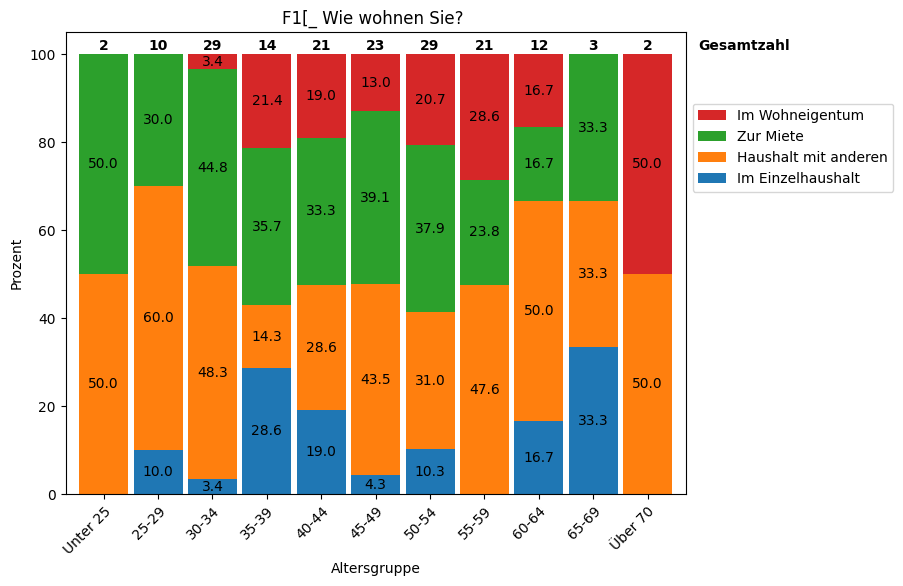

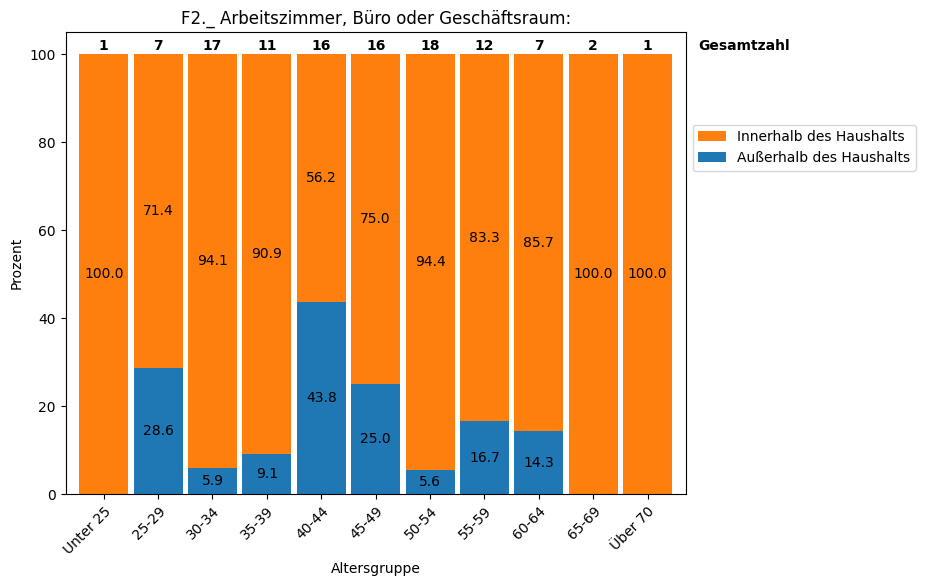

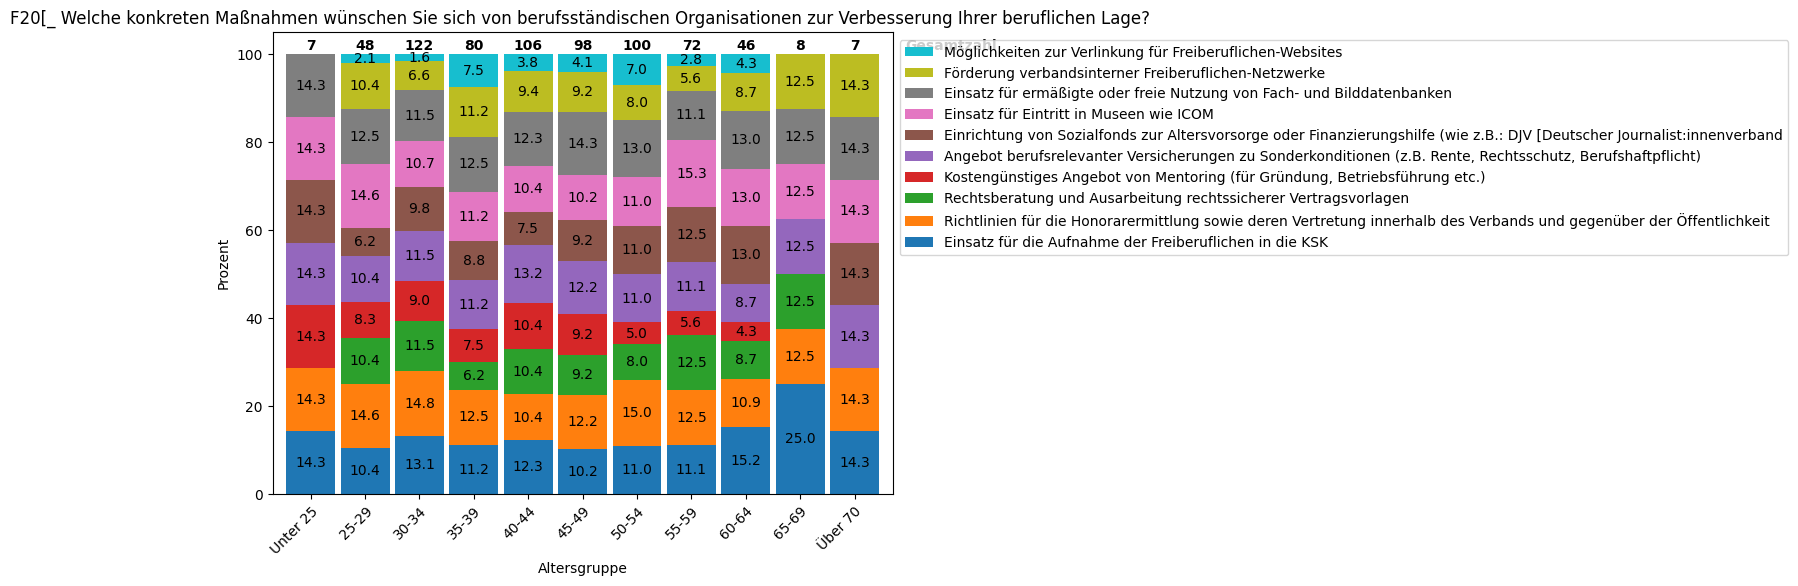

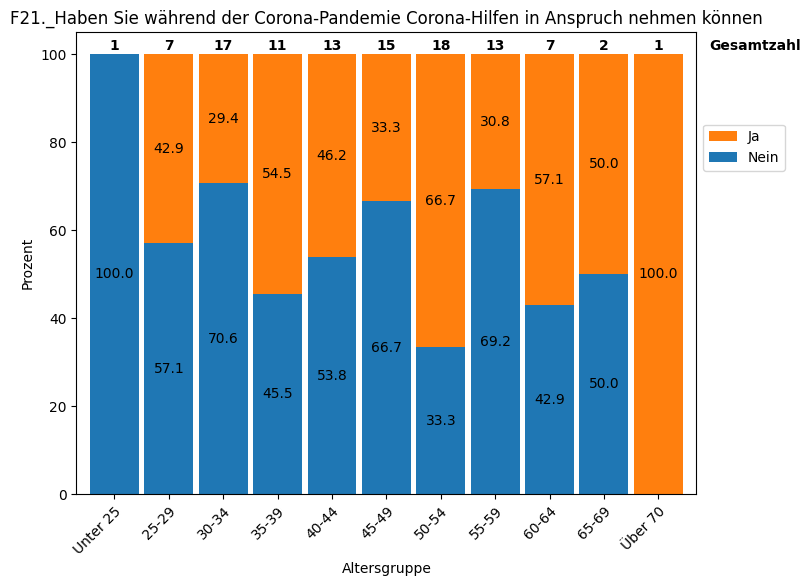

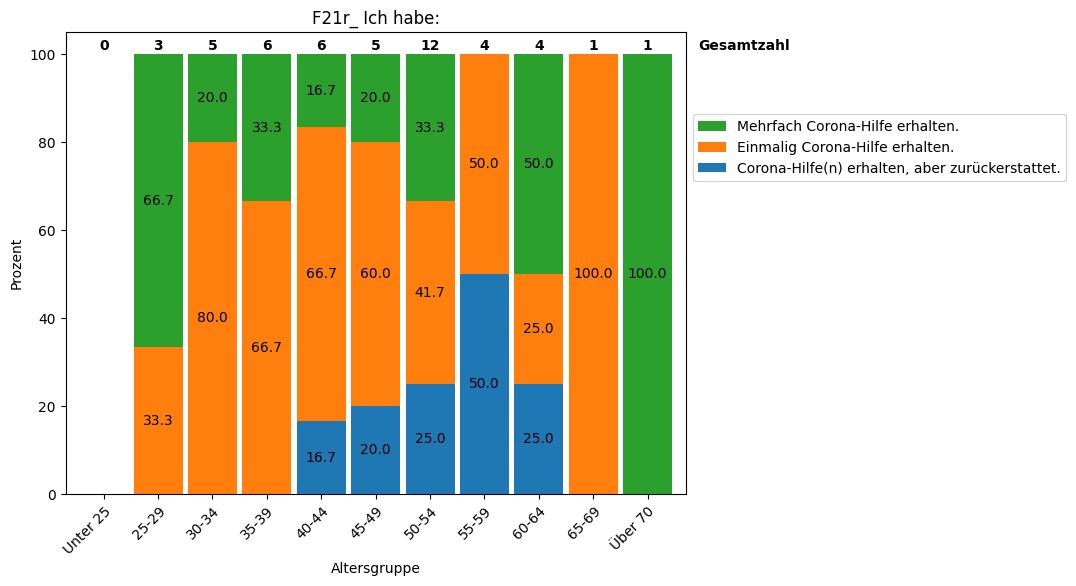

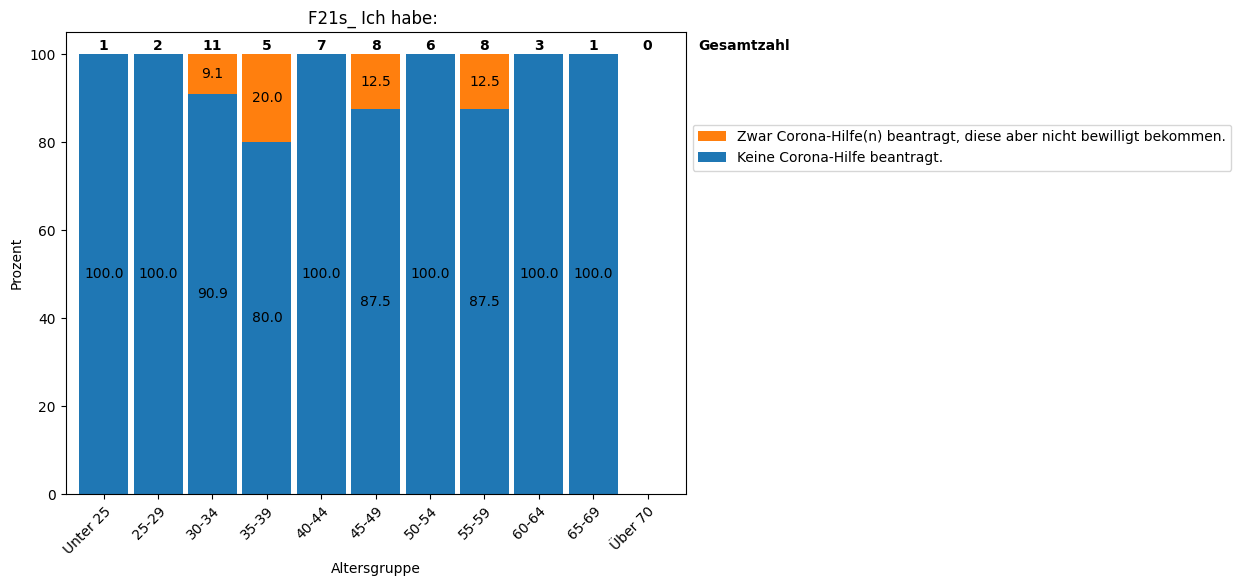

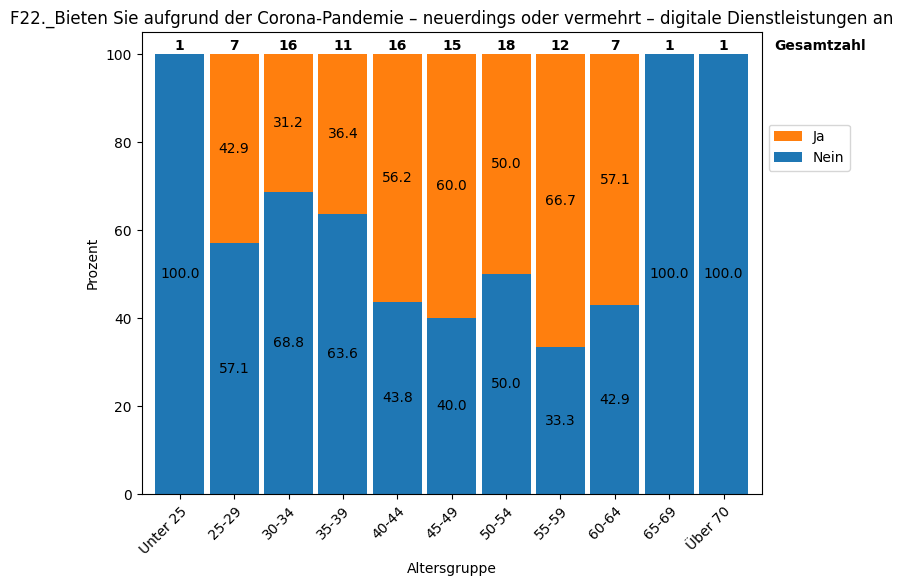

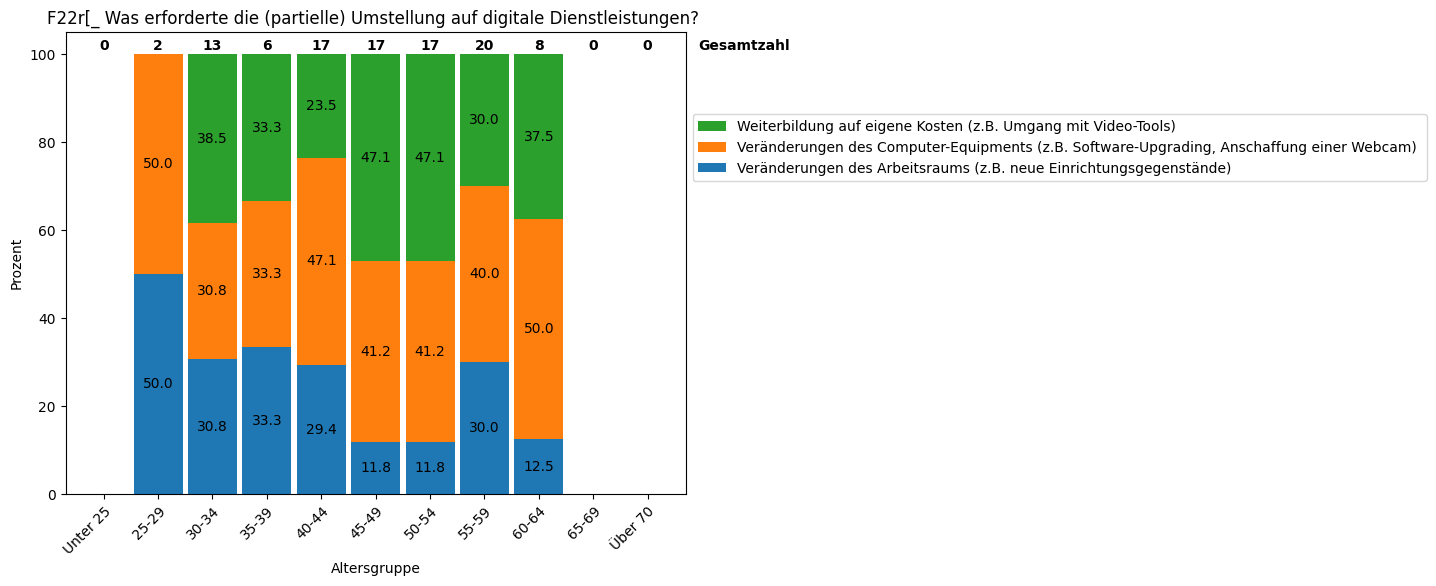

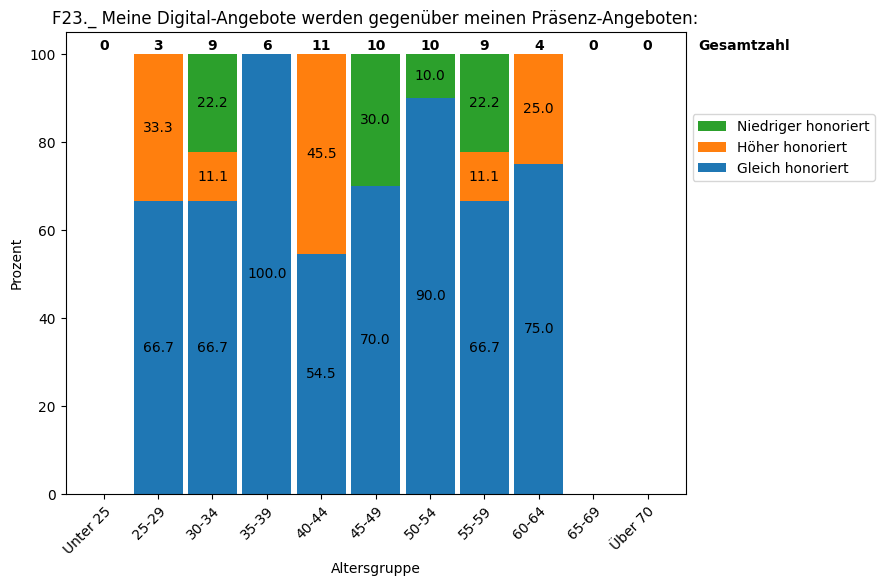

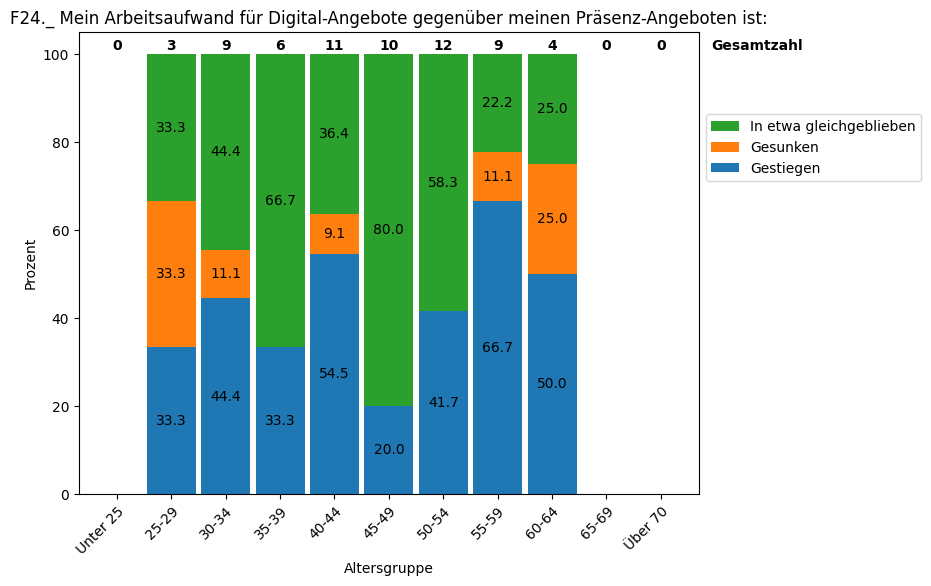

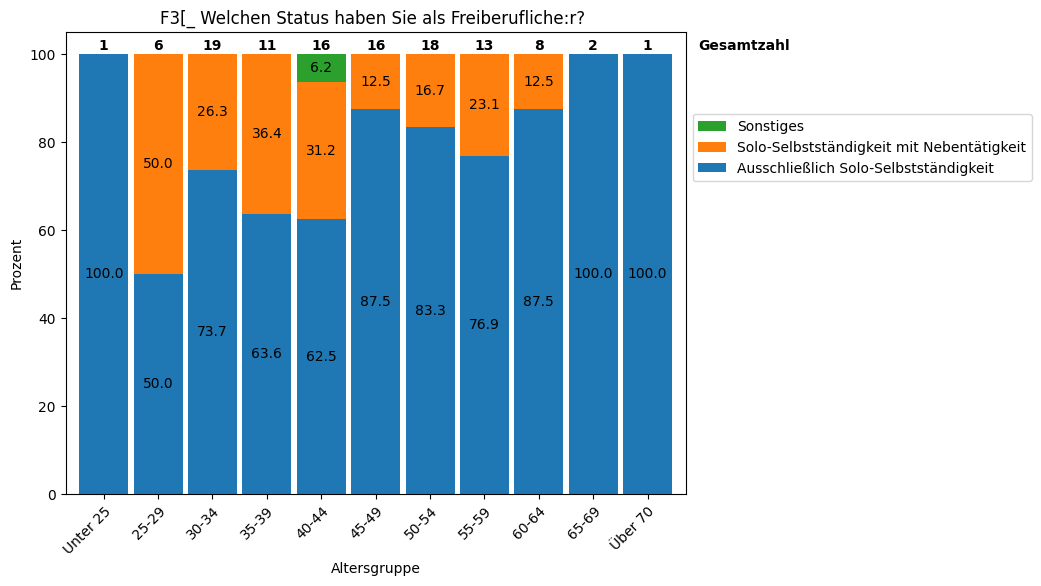

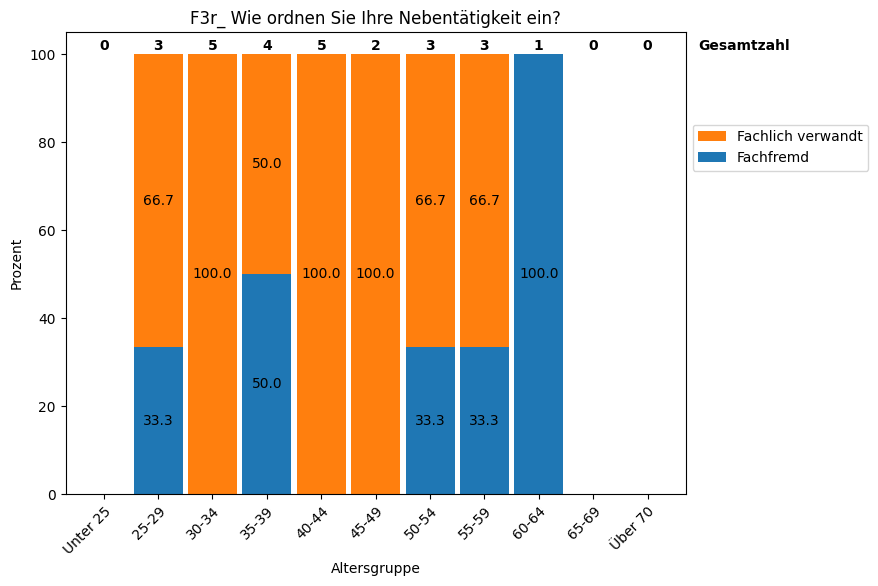

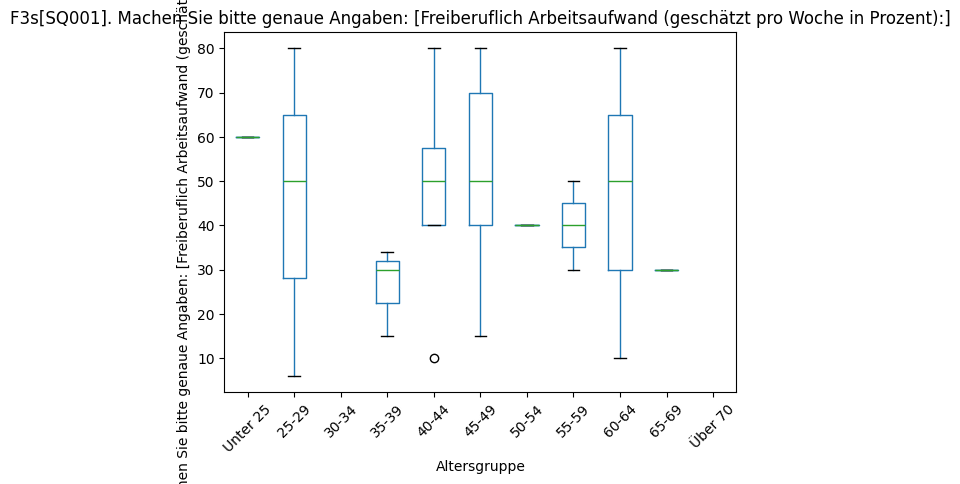

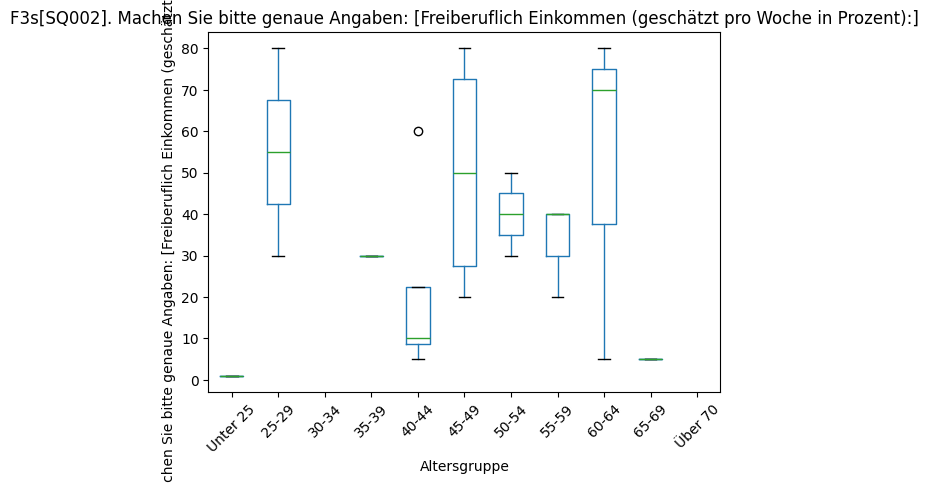

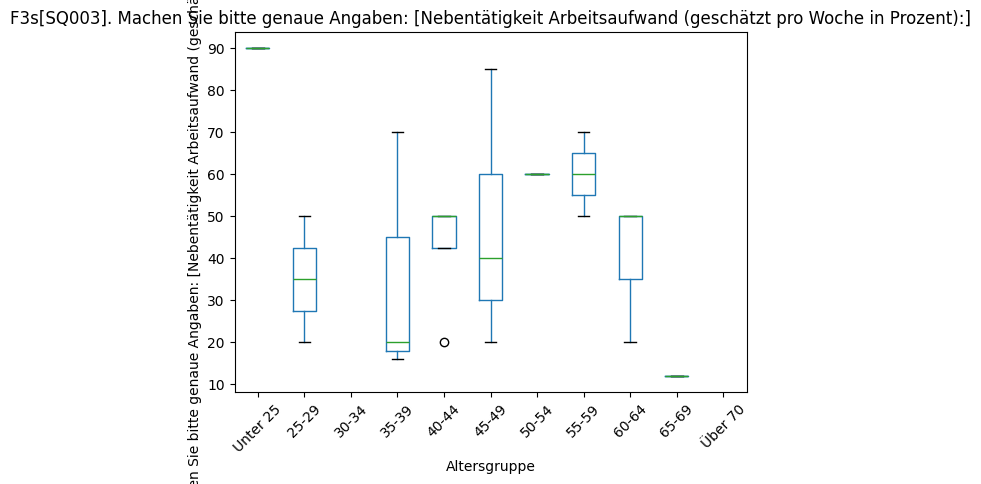

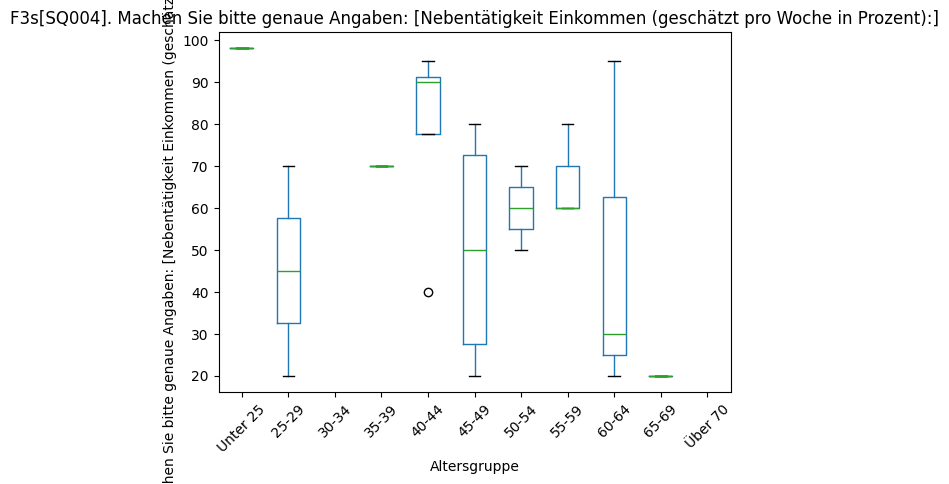

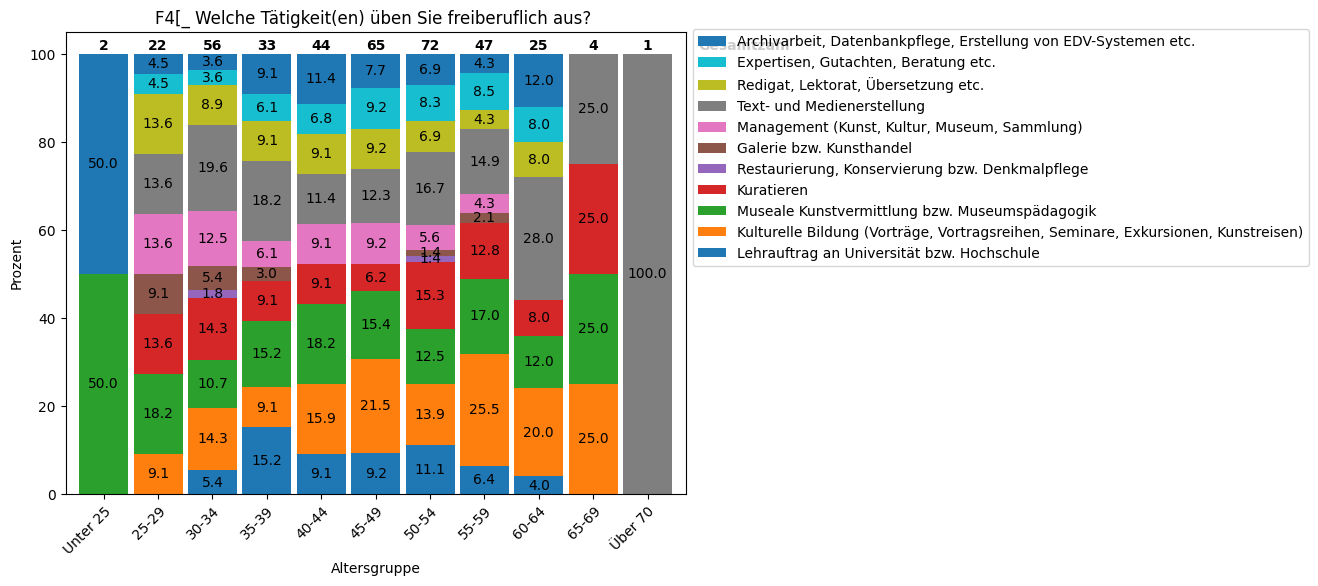

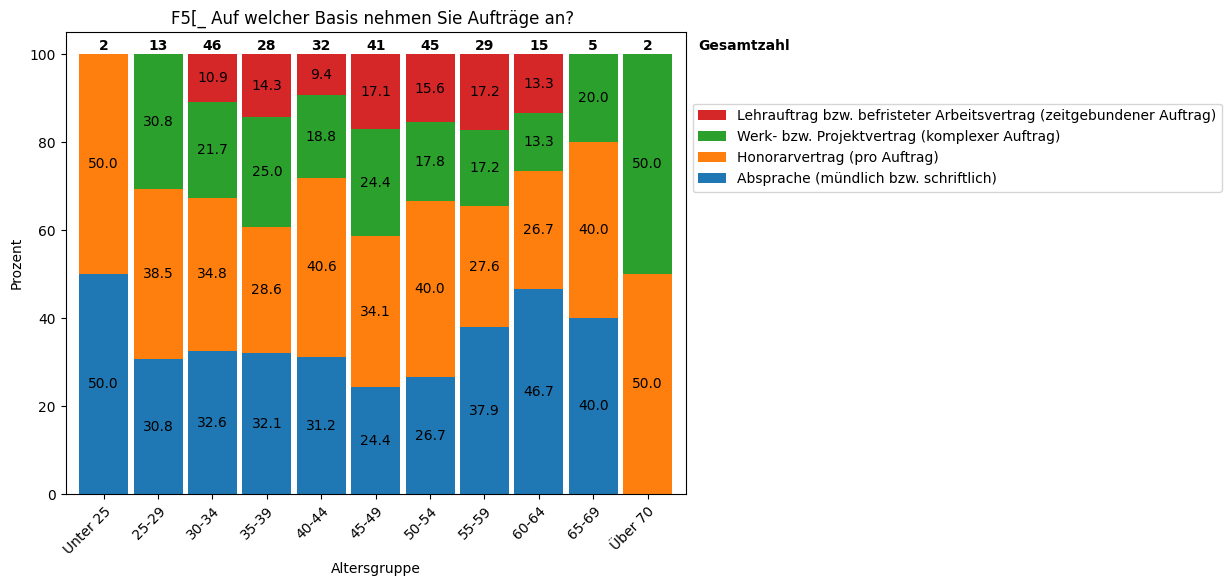

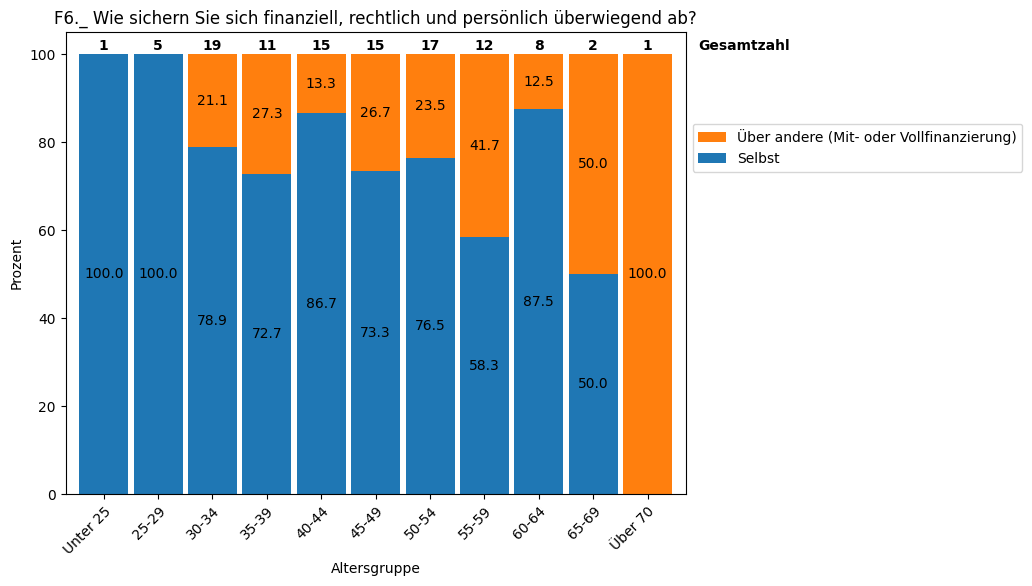

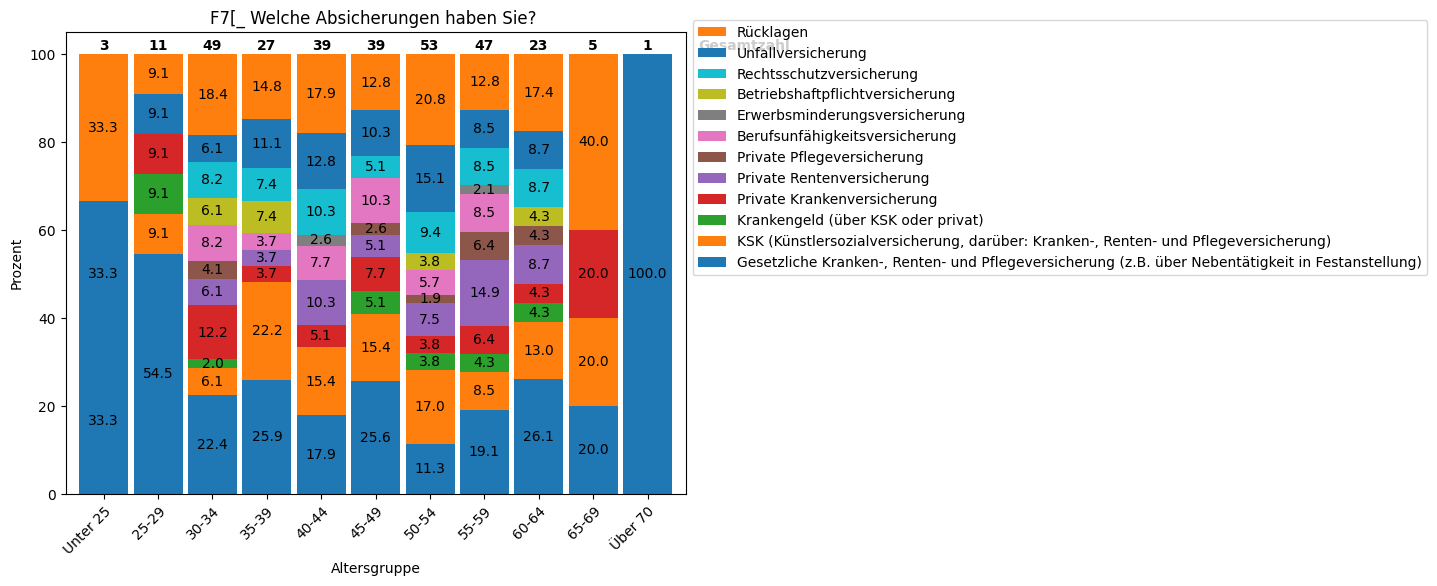

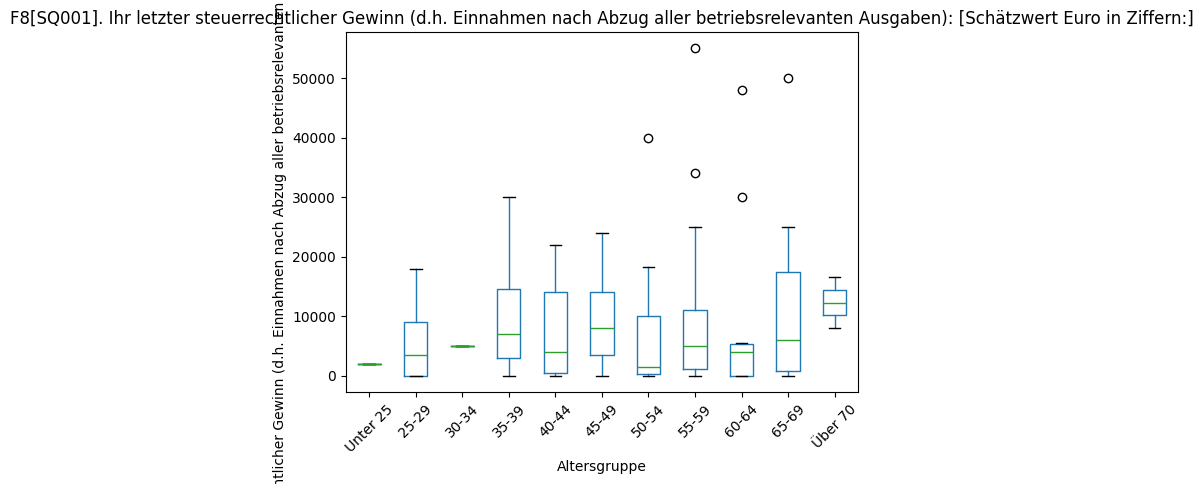

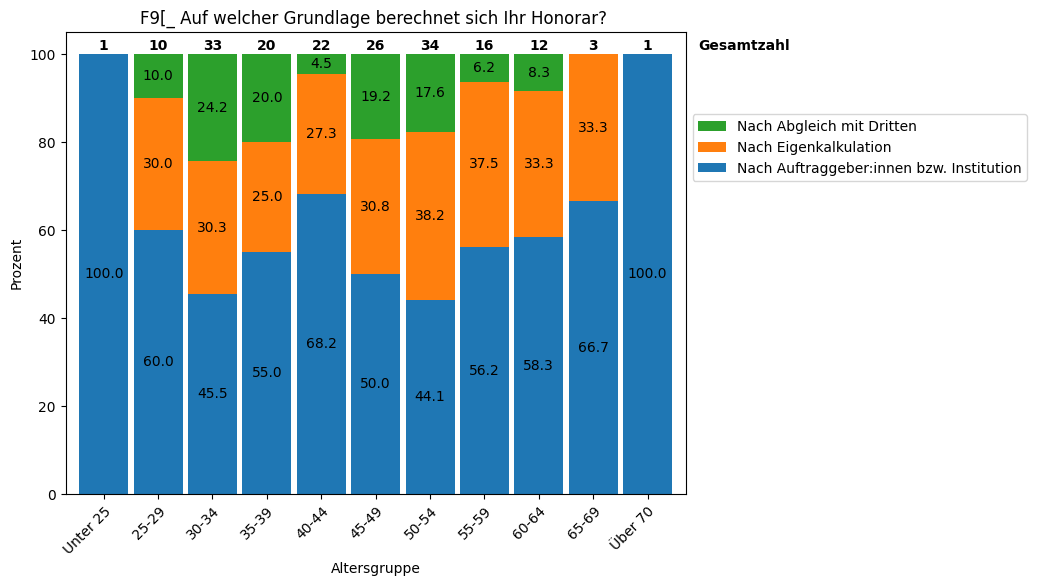

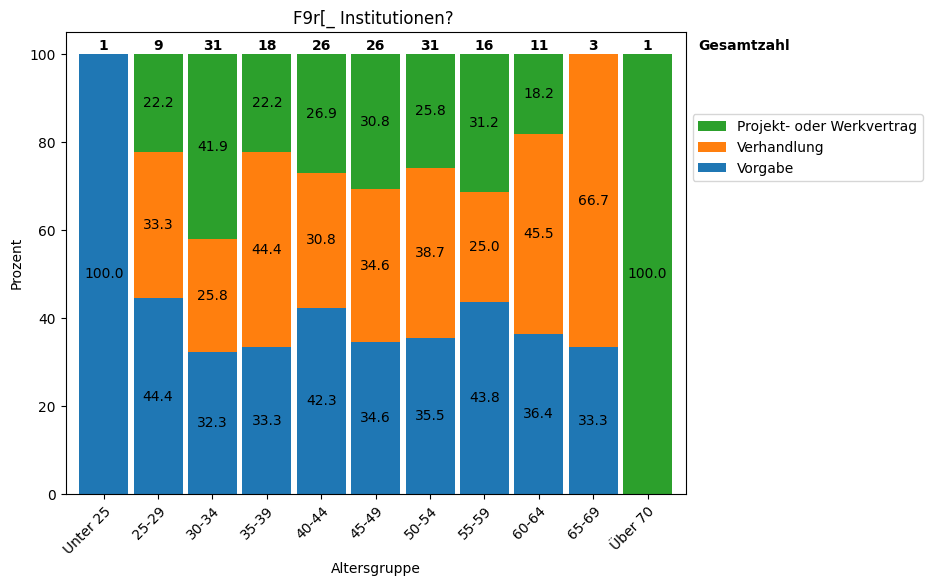

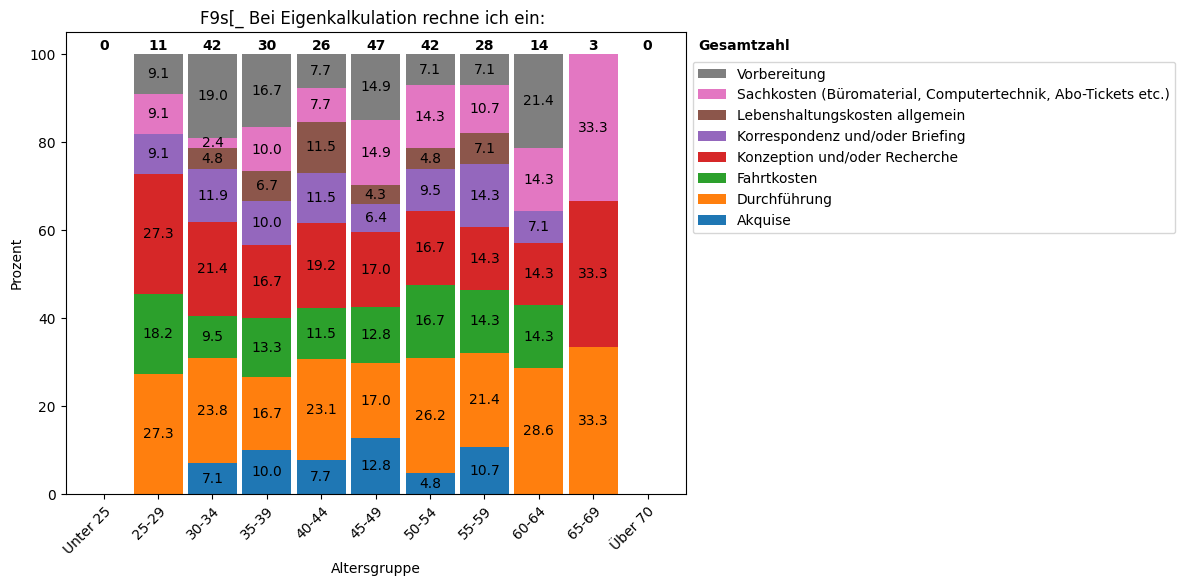

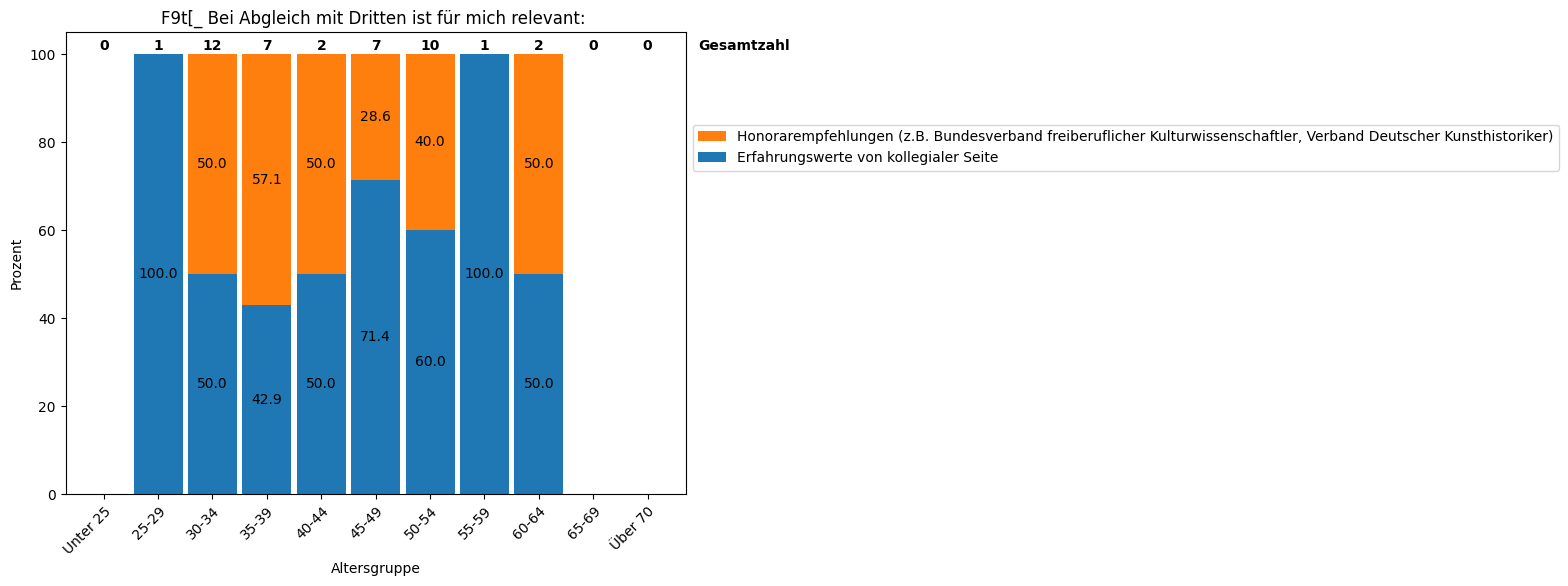

In [29]:
automated_graphs(ls_cols_age_level, adjusted_groups, 'AP1', ls_decoded_age_level, 'Altersgruppe')